In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from numba import njit

import itertools
import pandas as pd


plt.style.use('seaborn-v0_8-whitegrid')
# Global Configuration (Defaults)
NX = 81
NY = 81
OUTPUT_DIR = "simulation_results"

# Natural Convection: Numerical Analysis

**Project:** Numerical Analysis Research Project

**Reference:** The effect of boundary conditions and orientation on the natural convection in enclosure, Md Abdur Rahman

---

# Overview
This notebook implements a Finite Difference Method (FDM) to solve the 2D, steady-state, incompressible Boussinesq natural convection model in streamfunction–vorticity form for natural convection in a rectangular enclosure.

We use the Stream Function-Vorticity ($\Psi$-$\Omega$) formulation to reduce the complexity of the variable equations. This framework is designed to support:
* Clear Fluid: Standard natural convection.
* Porous Media: Flow described by the Darcy model.
* Coupled Heat & Mass Transfer: Including the Soret effect (thermo-diffusion).


**Overview Summary Table**

| Model | Physics | Primary Outputs | BC Modes |
|---|---|---|---|
| Clear fluid | Streamfunction-vorticity + energy + species | Nu, Sh, streamlines, fields | linear, adiabatic |
| Porous media | Darcy streamfunction + energy | Nu, streamlines, fields | side-heated, bottom-heated |

The objective is to validate the numerical solver and investigate the physics of buoyancy-driven flows under various non-dimensional parameters.

## Global Configuration & Parameters

The following section defines the general parameters for the simulation. Below is just a sample of what the parameters can look like:

```python
#parameters
MODEL_TYPE = 'CLEAR_FLUID'
NX = 81
NY = 81
A = 1.0

RA = 100
PR = 0.71
PHI_DEG = 90.0

SC = 2.0
SR = 0.5

TOLERANCE = 1e-6
MAX_ITER = 30000
OMEGA_SOR = 0.5

PLOT_RESULTS = True
SAVE_CSV = True
OUTPUT_DIR = "simulation_results"
```


* Geometry & Grid: Defines the resolution (`NX`, `NY`) and aspect ratio (`A`) of the cavity.
* Physics: Key non-dimensional numbers governing the flow:
    * Rayleigh Number ($Ra$): Strength of buoyancy forces relative to viscous forces.
    * Prandtl Number ($Pr$): Ratio of momentum diffusivity to thermal diffusivity.
    * Schmidt ($Sc$) & Soret ($Sr$): Parameters for mass transfer and coupled diffusion effects.
    * Inclination Angle (`PHI_DEG`): Orientation of the enclosure relative to gravity

* Solver Settings: Convergence criteria (`TOLERANCE`) and relaxation factors (`OMEGA_SOR`) for the iterative solver.

## Core Numerical Kernels

This section contains the performance-critical kernels compiled with `@njit`. The implementation follows a steady-state fixed-point iteration strategy: transport equations are updated using a relaxed Jacobi-style scheme with upwind advection, while the streamfunction is updated by repeated SOR sweeps of the Poisson equation. Boundary conditions are enforced explicitly after each outer iteration.


### 1) Streamfunction Poisson Update (`solve_poisson_psi_sor`)

The streamfunction $\Psi$ is obtained from the vorticity $\Omega$ by solving the Poisson equation
$$
\nabla^2 \Psi = -\Omega.
$$

A single **SOR (Gauss–Seidel) sweep** updates interior nodes using the 5-point Laplacian stencil:
$$
\Psi_{i,j}^{*}
=
\frac{
\frac{1}{dx^2}\left(\Psi_{i,j+1}+\Psi_{i,j-1}\right)
+
\frac{1}{dy^2}\left(\Psi_{i+1,j}+\Psi_{i-1,j}\right)
+
\Omega_{i,j}
}{
2\left(\frac{1}{dx^2}+\frac{1}{dy^2}\right)
},
$$
followed by relaxation
$$
\Psi_{i,j}^{(new)}=(1-\omega)\,\Psi_{i,j}^{(old)}+\omega\,\Psi_{i,j}^{*},
$$
where $\omega$ is the relaxation parameter `omega_sor`. Repeating this sweep within the outer loop drives the Poisson residual toward zero.

In [3]:
@njit(cache=True)
def solve_poisson_psi_sor(psi, omega, dx, dy, omega_sor):
    ny, nx = psi.shape
    inv_dx2 = 1.0 / (dx**2)
    inv_dy2 = 1.0 / (dy**2)
    geom_factor = 1.0 / (2.0 * (inv_dx2 + inv_dy2))
    
    for i in range(1, ny - 1):
        for j in range(1, nx - 1):
            psi_gs = geom_factor * (
                inv_dx2 * (psi[i, j+1] + psi[i, j-1]) + 
                inv_dy2 * (psi[i+1, j] + psi[i-1, j]) + 
                omega[i, j]
            )
            psi[i, j] = (1.0 - omega_sor) * psi[i, j] + omega_sor * psi_gs
    return psi




### 2) Generic Transport Update (`solve_transport_jacobi`)

This kernel advances generic steady advection–diffusion equations in the form
$$
\nabla^2 \phi \;-\; a\left(u\frac{\partial \phi}{\partial X}+v\frac{\partial \phi}{\partial Y}\right)\;+\;S \;=\; 0,
$$
where $\phi$ denotes one of $\theta$ (temperature), $\Omega$ (vorticity), or $C$ (concentration), $S$ is a supplied source term, and $a$ is the advection scaling factor `adv_coeff`.

Velocities are computed from the streamfunction using centered differences:
$$
u=\frac{\partial \Psi}{\partial Y}\approx\frac{\Psi_{i+1,j}-\Psi_{i-1,j}}{2\,dy},
\qquad
v=-\frac{\partial \Psi}{\partial X}\approx-\frac{\Psi_{i,j+1}-\Psi_{i,j-1}}{2\,dx}.
$$

Advection is discretized with a **first-order upwind scheme** (direction chosen by the sign of $u$ and $v$), while diffusion uses the standard 5-point stencil. The update is computed using the *previous* iterate `field_old` (Jacobi-style) and then relaxed:
$$
\phi_{i,j}^{(new)}=(1-\omega)\,\phi_{i,j}^{(old)}+\omega\,\phi_{i,j}^{*}.
$$


In [4]:
@njit(cache=True)
def solve_transport_jacobi(field, field_old, psi, source_term, dx, dy, omega_sor, adv_coeff):
    ny, nx = field.shape
    inv_dx2 = 1.0 / (dx**2)
    inv_dy2 = 1.0 / (dy**2)
    geom_factor = 1.0 / (2.0 * (inv_dx2 + inv_dy2))
    
    inv_dx, inv_dy = 1.0/dx, 1.0/dy
    inv_2dy, inv_2dx = 1.0/(2.0*dy), 1.0/(2.0*dx)

    for i in range(1, ny - 1):
        for j in range(1, nx - 1):
            # Velocity
            u =  (psi[i+1, j] - psi[i-1, j]) * inv_2dy
            v = -(psi[i, j+1] - psi[i, j-1]) * inv_2dx
            
            # Upwind Advection
            if u > 0: adv_x = u * (field_old[i, j] - field_old[i, j-1]) * inv_dx
            else:     adv_x = u * (field_old[i, j+1] - field_old[i, j]) * inv_dx
            if v > 0: adv_y = v * (field_old[i, j] - field_old[i-1, j]) * inv_dy
            else:     adv_y = v * (field_old[i+1, j] - field_old[i, j]) * inv_dy
            
            advection = adv_coeff * (adv_x + adv_y)
            
            # Diffusion
            laplacian = (inv_dx2 * (field_old[i, j+1] + field_old[i, j-1]) +
                         inv_dy2 * (field_old[i+1, j] + field_old[i-1, j]))
            
            # Update
            field_gs = geom_factor * (laplacian - advection + source_term[i, j])
            field[i, j] = (1.0 - omega_sor) * field_old[i, j] + omega_sor * field_gs
    return field




### 3) Boundary Condition Enforcement (`apply_boundary`)

Boundary conditions are enforced after each outer iteration to maintain consistency across $\Psi$, $\Omega$, $\theta$, and $C$.

**Streamfunction (no-slip enclosure):**
$$
\Psi=0 \quad \text{on all walls.}
$$

**Vorticity (wall closure via one-sided Laplacian of $\Psi$):**
For example, at the left wall $X=0$ (applied to interior wall-adjacent nodes),
$$
\Omega \approx -\frac{2\Psi_{wall\_adjacent}}{dx^2},
$$
with analogous expressions on the other walls using $dx$ or $dy$ as appropriate.

**Temperature and Concentration (left/right Dirichlet):**
$$
\theta(X=0)=1,\quad \theta(X=1)=0,\qquad
C(X=0)=1,\quad C(X=1)=0.
$$

**Top/bottom thermal boundary condition modes:**
- If `bc_linear=True`, the top and bottom walls are set to the linear profile
  $$
  \theta = 1-X,\qquad C=1-X.
  $$
- If `bc_linear=False`, the top/bottom thermal boundary is adiabatic for $\theta$ (zero normal gradient implemented by copying the adjacent interior row), while $C$ applies a Soret-coupled wall update consistent with the implemented model.



In [5]:
@njit(cache=True)
def apply_boundary(psi, omega, theta, C, x_coords, dx, dy, sr, bc_linear):
    """
    Applies boundary conditions.
    """
    ny, nx = psi.shape
    inv_dx2 = 1.0 / (dx**2)
    inv_dy2 = 1.0 / (dy**2)

    # Streamfunction (No slip at walls)
    psi[:, 0] = 0.0; psi[:, -1] = 0.0
    psi[0, :] = 0.0; psi[-1, :] = 0.0
    
    # Vorticity Wall BCs (Jensen's formula / One-sided)
    omega[1:-1, 0]  = -2.0 * psi[1:-1, 1] * inv_dx2    # Left
    omega[1:-1, -1] = -2.0 * psi[1:-1, -2] * inv_dx2   # Right
    omega[0, :]     = -2.0 * psi[1, :] * inv_dy2       # Bottom
    omega[-1, :]    = -2.0 * psi[-2, :] * inv_dy2      # Top

    # Temperature & Concentration (Dirichlet Walls)
    theta[:, 0] = 1.0; theta[:, -1] = 0.0
    C[:, 0] = 1.0; C[:, -1] = 0.0

    # Top/Bottom BCs
    if bc_linear:
        for j in range(nx):
            val = 1.0 - x_coords[j]
            theta[0, j] = val; theta[-1, j] = val
            C[0, j] = val; C[-1, j] = val
    else:
        # Adiabatic (No Flux) for Theta
        theta[0, :] = theta[1, :]
        theta[-1, :] = theta[-2, :]
        
        # Soret-coupled wall update for C
        for j in range(nx):
            C[0, j] = C[1, j] - sr * (theta[1, j] - theta[0, j])
            C[-1, j] = C[-2, j] + sr * (theta[-1, j] - theta[-2, j])

@njit(cache=True)
def apply_boundary_clear(psi, omega, theta, C, x, dx, dy, bc_linear):
    ny, nx = psi.shape
    inv_dx2, inv_dy2 = 1.0/dx**2, 1.0/dy**2
    psi[:, 0] = 0.0; psi[:, -1] = 0.0; psi[0, :] = 0.0; psi[-1, :] = 0.0
    omega[1:-1, 0] = -2.0*psi[1:-1, 1]*inv_dx2; omega[1:-1, -1] = -2.0*psi[1:-1, -2]*inv_dx2
    omega[0, :] = -2.0*psi[1, :]*inv_dy2; omega[-1, :] = -2.0*psi[-2, :]*inv_dy2
    theta[:, 0] = 1.0; theta[:, -1] = 0.0; C[:, 0] = 1.0; C[:, -1] = 0.0
    if bc_linear:
        for j in range(nx):
            val = 1.0 - x[j]
            theta[0, j] = val; theta[-1, j] = val; C[0, j] = val; C[-1, j] = val
    else:
        theta[0, :] = theta[1, :]; theta[-1, :] = theta[-2, :]
        C[0, :] = C[1, :]; C[-1, :] = C[-2, :]

### Mathematical Utility Functions

#### Discrete Laplacian (`compute_laplacian`)

The helper function `compute_laplacian` evaluates the second-order finite-difference
approximation of the Laplacian operator,
$$
\nabla^2 \phi
\approx
\frac{\phi_{i,j+1} + \phi_{i,j-1} - 2\phi_{i,j}}{dx^2}
+
\frac{\phi_{i+1,j} + \phi_{i-1,j} - 2\phi_{i,j}}{dy^2}.
$$

This operator is used explicitly to construct source terms for the Soret effect,
where thermal gradients drive mass diffusion in the concentration equation.

---

Together, these kernels provide robust enforcement of boundary physics and
support accurate coupling between temperature, concentration, and momentum fields.

In [6]:
@njit(cache=True)
def compute_laplacian(field, dx, dy):
    ny, nx = field.shape
    res = np.zeros_like(field)
    idx2 = 1.0/dx**2
    idy2 = 1.0/dy**2
    
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            res[i,j] = idx2 * (field[i, j+1] + field[i, j-1] - 2*field[i,j]) + \
                       idy2 * (field[i+1, j] + field[i-1, j] - 2*field[i,j])
    return res


### 4) Coupled Outer Iteration (`run_simulation`)

The `run_simulation` routine performs a steady-state coupled fixed-point iteration:

1. **Energy equation:** update $\theta$ using `solve_transport_jacobi`.
2. **Concentration equation:** update $C$ using a Soret-driven source constructed from the discrete Laplacian of $\theta$.
3. **Clear-fluid momentum coupling (if enabled):**
   - build a buoyancy-driven vorticity source using centered gradients
     $$
     \frac{\partial \theta}{\partial X}\approx\frac{\theta_{i,j+1}-\theta_{i,j-1}}{2\,dx},
     \qquad
     \frac{\partial \theta}{\partial Y}\approx\frac{\theta_{i+1,j}-\theta_{i-1,j}}{2\,dy},
     $$
     and orientation $(\sin\phi,\cos\phi)$,
   - update $\Omega$ via the transport kernel,
   - update $\Psi$ via the Poisson SOR sweep.

4. **Apply boundary conditions** with `apply_boundary`.

5. **Convergence monitoring:** every 500 iterations, compute the maximum absolute update
$$
\text{err}=\max\left(\|\Psi-\Psi_{old}\|_\infty,\;\|\theta-\theta_{old}\|_\infty,\;\|C-C_{old}\|_\infty\right),
$$
and declare convergence if $\text{err} < \text{tol}$. The routine returns the converged fields and the iteration count.

In [7]:
@njit(cache=True)
def run_simulation(psi, omega, theta, C, x, dx, dy, 
                   ra, pr, sc, sr, phi_rad, 
                   omega_sor, tol, max_iter, 
                   is_clear_fluid, bc_linear):
    
    ny, nx = psi.shape
    source_theta = np.zeros((ny, nx))
    
    iter_count = 0
    converged = False
    
    # Pre-calculate constants for loop
    inv_2dx = 1.0 / (2*dx)
    inv_2dy = 1.0 / (2*dy)
    sin_phi = np.sin(phi_rad)
    cos_phi = np.cos(phi_rad)
    coeff_C = 1.0 / (pr/sc)
    coeff_omega = 1.0 / pr
    soret_prefactor = -(sr / (pr / sc))

    for it in range(1, max_iter + 1):
        psi_old, omega_old = psi.copy(), omega.copy()
        theta_old, C_old = theta.copy(), C.copy()
        
        # 1. Solve Energy (Theta)
        solve_transport_jacobi(theta, theta_old, psi, source_theta, dx, dy, omega_sor, 1.0)
        
        # 2. Solve Concentration (C) with Soret Source
        theta_lap = compute_laplacian(theta, dx, dy)
        source_C = soret_prefactor * theta_lap
        solve_transport_jacobi(C, C_old, psi, source_C, dx, dy, omega_sor, coeff_C)
        
        # 3. Solve Momentum (Omega & Psi)
        if is_clear_fluid:
            source_omega = np.zeros((ny, nx))
            # Calculate Buoyancy Term manually to avoid function overhead
            for i in range(1, ny-1):
                for j in range(1, nx-1):
                    dTdx = (theta[i, j+1] - theta[i, j-1]) * inv_2dx
                    dTdy = (theta[i+1, j] - theta[i-1, j]) * inv_2dy
                    source_omega[i, j] = ra * (sin_phi * dTdx - cos_phi * dTdy)
            
            solve_transport_jacobi(omega, omega_old, psi, source_omega, dx, dy, omega_sor, coeff_omega)
            solve_poisson_psi_sor(psi, omega, dx, dy, omega_sor)

        # 4. Apply Boundaries
        apply_boundary(psi, omega, theta, C, x, dx, dy, sr, bc_linear)
        
        # 5. Convergence Check (every 500 iters)
        if it % 500 == 0:
            err = 0.0
            # Numba compatible max search
            for i in range(ny):
                for j in range(nx):
                    e1 = abs(psi[i,j] - psi_old[i,j])
                    e2 = abs(theta[i,j] - theta_old[i,j])
                    e3 = abs(C[i,j] - C_old[i,j])
                    if e1 > err: err = e1
                    if e2 > err: err = e2
                    if e3 > err: err = e3
            
            if err < tol:
                iter_count = it
                converged = True
                break
                
    if not converged: iter_count = max_iter
    return psi, omega, theta, C, iter_count

### Field initialization and wall-transport metrics

This section defines utilities to (i) initialize the primary fields for the streamfunction–vorticity natural convection solver and (ii) compute global heat and mass transfer rates at the hot wall.

- **`initialize_fields(nx, ny, a, bc_type)`**
  - Allocates and returns zero-initialized arrays for:
    - Streamfunction: `psi` with shape `(ny, nx)`
    - Vorticity: `omega` with shape `(ny, nx)`
    - Temperature: `theta` with shape `(ny, nx)`
    - Solute concentration: `C` with shape `(ny, nx)`
  - Builds a uniform grid in the computational domain:
    - $x \in [0,1]$ with spacing $dx = \frac{1}{nx-1}$
    - $y \in [0,a]$ with spacing $dy = \frac{a}{ny-1}$ (the explicit `y` array is optional for the solver but useful for plotting)
  - Applies baseline Dirichlet boundary conditions on the **vertical walls**:
    - Left wall (“hot”): `theta[:,0]=1`, `C[:,0]=1`
    - Right wall (“cold”): `theta[:,-1]=0`, `C[:,-1]=0`
  - If `bc_type == "linear"`, overwrites the full domain with a **linear profile** in $x$:
    - $\theta(x)=1-x$, $C(x)=1-x$, replicated for every $y$-row
  - Returns the fields and grid descriptors: `psi, omega, theta, C, x, dx, dy`.

- **`calculate_nusselt(theta, dx)`**
  - Estimates the **average Nusselt number** at the hot wall by computing the wall-normal temperature gradient at $x=0$.
  - Uses a **second-order forward difference**:
    $$
      \left.\frac{\partial \theta}{\partial x}\right|_{x=0}
      \approx \frac{-3\theta_0 + 4\theta_1 - \theta_2}{2\,dx}
    $$
  - Returns the domain-average heat flux measure:
    $$
      \mathrm{Nu} \equiv \left\langle -\frac{\partial \theta}{\partial x}\Big|_{x=0} \right\rangle_y
    $$
    implemented as the mean over all $y$ indices.

- **`calculate_sherwood(C, dx)`**
  - Analogous to `calculate_nusselt`, but for solute concentration at the hot wall.
  - Computes the second-order forward-difference gradient of $C$ at $x=0$ and returns:
    $$
      \mathrm{Sh} \equiv \left\langle -\frac{\partial C}{\partial x}\Big|_{x=0} \right\rangle_y
    $$


In [8]:
def initialize_fields(nx, ny, a, bc_type):
    psi = np.zeros((ny, nx))
    theta = np.zeros((ny, nx))
    omega = np.zeros((ny, nx))
    C = np.zeros((ny, nx))
    
    x = np.linspace(0, 1, nx)
    # y = np.linspace(0, a, ny) # y array not strictly needed for solver but good for plotting
    dx = 1.0 / (nx - 1)
    dy = a / (ny - 1)
    
    theta[:, 0] = 1.0
    theta[:, -1] = 0.0
    C[:, 0] = 1.0
    C[:, -1] = 0.0

    if bc_type == 'linear':
        for j in range(ny):
            theta[j, :] = 1.0 - x
            C[j, :] = 1.0 - x
            
    return psi, omega, theta, C, x, dx, dy

def calculate_nusselt(theta, dx):
    # Forward difference 2nd order: (-3f0 + 4f1 - f2) / 2h
    dtheta_dx_hot_wall = (-3 * theta[:, 0] + 4 * theta[:, 1] - theta[:, 2]) / (2 * dx)
    return np.mean(-dtheta_dx_hot_wall)

def calculate_sherwood(C, dx):
    dC_dx_hot_wall = (-3 * C[:, 0] + 4 * C[:, 1] - C[:, 2]) / (2 * dx)
    return np.mean(-dC_dx_hot_wall)

### Unified porous-media solver kernel (Darcy + advection–diffusion)

This section implements a single, JIT-compiled iteration kernel for **porous-media natural convection** under the **Darcy model**, with a switchable thermal boundary-condition mode.

- **Function:** `solve_porous_unified(psi, theta, dx, dy, Ra_W, phi_rad, max_iter, tol, urf, bc_mode)`
  - Decorated with `@njit(cache=True)` to compile with Numba for performance.
  - Solves, in a coupled fixed-point iteration:
    - **Temperature transport (advection–diffusion)** for `theta`
    - **Darcy streamfunction equation** for `psi` with buoyancy forcing
  - Returns updated fields `(psi, theta)` and `iter_count` (iteration at convergence or `max_iter`).

---

#### 1) Geometry and constants
- Precomputes stencil constants for a uniform grid:
  - $ \Delta x = dx,\; \Delta y = dy $
  - $1/dx^2,\; 1/dy^2$ and centered-difference factors $1/(2dx),\; 1/(2dy)$
  - A common Jacobi-like denominator:
    $$
      \text{geom_factor} = \frac{1}{2\left(\frac{1}{dx^2}+\frac{1}{dy^2}\right)}
    $$
- Computes orientation factors from the cavity tilt angle $\phi$:
    $$
      \sin\phi,\; \cos\phi
    $$
  used to project buoyancy forcing along the rotated gravity direction.

---

#### 2) Iterative update loop (fixed-point / relaxed Jacobi)
For each iteration $it = 1,\dots,\text{max_iter}$:

- **Snapshot old fields:** copies `psi` and `theta` into `psi_old`, `theta_old` for a consistent Jacobi-style update.

- **Interior cell update** for $i=1\ldots ny-2,\; j=1\ldots nx-2$:
  - **Centered gradients** (from old fields):
    $$
      \psi_x,\; \psi_y,\; \theta_x,\; \theta_y
    $$
  - **Temperature equation (advection–diffusion form):**
    - Jacobian-style advection term:
      $$
        \mathcal{A} = \psi_y\,\theta_x - \psi_x\,\theta_y
      $$
    - 5-point Laplacian contribution assembled via neighbor sums.
    - Forms a new iterate `theta_new` and applies **under-relaxation**:
      $$
        \theta^{(new)} \leftarrow (1-\text{urf})\,\theta^{(old)} + \text{urf}\,\theta_{\text{Jacobi}}
      $$
  - **Darcy streamfunction equation:**
    - Uses a Laplacian update for `psi` driven by buoyancy:
      $$
        \nabla^2 \psi = -\,\text{(buoyancy forcing)}
      $$
    - Buoyancy forcing is computed from rotated temperature gradients:
      $$
        \mathcal{B} = Ra_W\left(\sin\phi\,\theta_x - \cos\phi\,\theta_y\right)
      $$
    - Applies the same relaxation form to update `psi`.

- **Convergence monitor:** tracks the maximum interior change in `psi`:
  $$
    \max_{i,j}\left|\psi^{(new)}_{i,j}-\psi^{(old)}_{i,j}\right|
  $$
  and checks it against `tol` every 1000 iterations.

---

#### 3) Boundary-condition switching (`bc_mode`)
The kernel supports two common cavity setups by switching only the **temperature boundary conditions**:

- **`bc_mode = 0` (Side-heated vertical cavity):**
  - Dirichlet on side walls:
    - Left wall hot: $\theta=1$
    - Right wall cold: $\theta=0$
  - Adiabatic (Neumann) on top/bottom implemented by copying adjacent interior values:
    $$
      \theta_{bottom} \leftarrow \theta_{1,*},\quad \theta_{top} \leftarrow \theta_{-2,*}
    $$

- **`bc_mode = 1` (Rayleigh–Bénard: bottom-heated):**
  - Dirichlet on horizontal walls:
    - Bottom hot: $\theta=1$
    - Top cold: $\theta=0$
  - Adiabatic (Neumann) on left/right:
    $$
      \theta_{left} \leftarrow \theta_{*,1},\quad \theta_{right} \leftarrow \theta_{*,-2}
    $$

- **Streamfunction boundary condition:**
  - `psi` is implicitly treated as **impermeable** with $\psi=0$ at walls by not updating boundary nodes (i.e., boundary values remain at their initialized values).

---

#### 4) Outputs
- If convergence is detected (`max_err < tol` at a check point), the solver returns early with:
  - `iter_count = it`
- Otherwise:
  - `iter_count = max_iter`
- Final return signature:
  - `return psi, theta, iter_count`


In [19]:
@njit(cache=True)
def solve_porous_unified(psi, theta, dx, dy, Ra_W, phi_rad, max_iter, tol, urf, bc_mode):
    """
    Unified Kernel for Porous Media.
    bc_mode 0: Side-Heated (Standard Vertical Cavity)
    bc_mode 1: Bottom-Heated (Rayleigh-Benard)
    """
    ny, nx = psi.shape
    
    # Precompute geometric constants
    inv_dx2 = 1.0 / (dx**2)
    inv_dy2 = 1.0 / (dy**2)
    inv_2dx = 1.0 / (2.0 * dx)
    inv_2dy = 1.0 / (2.0 * dy)
    geom_factor = 1.0 / (2.0 * (inv_dx2 + inv_dy2))
    
    sin_phi = np.sin(phi_rad)
    cos_phi = np.cos(phi_rad)

    # Allocate old arrays
    psi_old = np.empty_like(psi)
    theta_old = np.empty_like(theta)
    
    converged = False
    iter_count = 0
    
    for it in range(1, max_iter + 1):
        # 1. Snapshot old fields
        for i in range(ny):
            for j in range(nx):
                psi_old[i, j] = psi[i, j]
                theta_old[i, j] = theta[i, j]
        
        max_err = 0.0
        
        # 2. Interior Update (Same PDE for both cases)
        for i in range(1, ny - 1):
            for j in range(1, nx - 1):
                # Gradients
                dpsi_dy   = (psi_old[i+1, j] - psi_old[i-1, j]) * inv_2dy
                dpsi_dx   = (psi_old[i, j+1] - psi_old[i, j-1]) * inv_2dx
                dtheta_dy = (theta_old[i+1, j] - theta_old[i-1, j]) * inv_2dy
                dtheta_dx = (theta_old[i, j+1] - theta_old[i, j-1]) * inv_2dx
                
                # Theta Equation (Advection-Diffusion)
                advection = dpsi_dy * dtheta_dx - dpsi_dx * dtheta_dy
                lap_theta = inv_dx2 * (theta_old[i, j+1] + theta_old[i, j-1]) + \
                            inv_dy2 * (theta_old[i+1, j] + theta_old[i-1, j])
                
                theta_new = geom_factor * (lap_theta - advection)
                theta[i, j] = (1.0 - urf) * theta_old[i, j] + urf * theta_new
                
                # Psi Equation (Darcy: Laplacian Psi = -Ra * Buoyancy)
                buoyancy = Ra_W * (sin_phi * dtheta_dx - cos_phi * dtheta_dy)
                lap_psi  = inv_dx2 * (psi_old[i, j+1] + psi_old[i, j-1]) + \
                           inv_dy2 * (psi_old[i+1, j] + psi_old[i-1, j])
                
                psi_new = geom_factor * (lap_psi + buoyancy)
                psi[i, j] = (1.0 - urf) * psi_old[i, j] + urf * psi_new

                # Track max change for convergence
                diff = abs(psi[i, j] - psi_old[i, j])
                if diff > max_err:
                    max_err = diff

        # 3. Apply Boundary Conditions (Switched by bc_mode)
        if bc_mode == 0: 
            # --- STANDARD: Side Heated ---
            # Theta: Left=1, Right=0
            # Walls: Adiabatic Top/Bottom
            for j in range(nx):
                theta[0, j] = theta[1, j]       # Bottom Adiabatic
                theta[-1, j] = theta[-2, j]     # Top Adiabatic
            
            # Enforce Dirichlet Sides
            for i in range(ny):
                theta[i, 0] = 1.0
                theta[i, -1] = 0.0

        elif bc_mode == 1:
            # --- RAYLEIGH-BENARD: Bottom Heated ---
            # Theta: Bottom=1, Top=0
            # Walls: Adiabatic Left/Right
            for i in range(ny):
                theta[i, 0] = theta[i, 1]       # Left Adiabatic
                theta[i, -1] = theta[i, -2]     # Right Adiabatic
            
            # Enforce Dirichlet Top/Bottom
            for j in range(nx):
                theta[0, j] = 1.0  # Bottom Hot
                theta[-1, j] = 0.0 # Top Cold
                
        # Psi is always 0 on all walls (Impermeable) - naturally handled by skipping boundary update

        # 4. Check Convergence
        if it % 1000 == 0:
            if max_err < tol:
                iter_count = it
                converged = True
                break
    
    if not converged: iter_count = max_iter
    return psi, theta, iter_count

## Simulation Wrapper

The `main_solver` function provides a high-level interface between the Numba-accelerated kernels and the Python workflow. It performs the following tasks:

1. **Grid Initialization:**  
   A uniform grid is generated on the nondimensional domain $0 \le X \le 1$, $0 \le Y \le A$, with spacings  
   $dx = \frac{1}{nx-1}$ and $dy = \frac{A}{ny-1}$.

2. **Field Allocation:**  
   The primary fields are allocated as zero arrays: $(\Psi, \Omega, \theta, C)$. The inclination angle is converted to radians via $\phi = \mathrm{deg2rad}(\phi_{\mathrm{deg}})$.

3. **Model Dispatch (Porous vs. Clear Fluid):**  
   The solver branches by `config['model_type']`:

   - **Branch A: Porous Media (`POROUS_MEDIA`)**  
     1. **Automatic BC Mode Detection:**  
        The wrapper detects a Rayleigh–Bénard configuration when the cavity is nearly vertical, i.e. $|\phi_{\mathrm{deg}}| < 5^\circ$ or $|\phi_{\mathrm{deg}} - 180^\circ| < 5^\circ$. In that case it sets `bc_mode = 1` (bottom-heated); otherwise it uses `bc_mode = 0` (side-heated).

     2. **Initial Temperature Profile:**  
        - For `bc_mode = 1` (bottom-heated), the initial condition is a vertical conduction gradient,
          $$\theta(Y) \approx 1 - \frac{Y}{A},$$
          implemented discretely as $\theta_i = 1 - \frac{i}{ny-1}$, and small random perturbations are added to trigger convective instability.
        - For `bc_mode = 0` (side-heated), the initial condition is a horizontal conduction gradient,
          $$\theta(X) \approx 1 - X,$$
          implemented discretely as $\theta_j = 1 - \frac{j}{nx-1}$.

     3. **Kernel Execution:**  
        The wrapper calls the unified porous-media kernel `solve_porous_unified(...)`, typically using under-relaxation ($\mathrm{urf} \lesssim 1$) to stabilize convergence.

     4. **Heat-Transfer Metric (Mode Dependent):**  
        The wall gradient uses a second-order one-sided forward derivative. For side-heated cases ($X=0$),
        $$\left.\frac{\partial \theta}{\partial X}\right|_{X=0} \approx \frac{-3\theta_0 + 4\theta_1 - \theta_2}{2\,dx},$$
        while for bottom-heated cases ($Y=0$),
        $$\left.\frac{\partial \theta}{\partial Y}\right|_{Y=0} \approx \frac{-3\theta_0 + 4\theta_1 - \theta_2}{2\,dy}.$$
        The local Nusselt number is defined as the negative wall-normal temperature gradient, and the reported value is the wall average,
        $$Nu_{\mathrm{avg}} = \langle Nu_{\mathrm{local}} \rangle.$$
        (Mass transfer is disabled in this branch, so $Sh_{\mathrm{avg}} = 0$.)

   - **Branch B: Clear Fluid (default)**  
     1. **Boundary and Initial Conditions:**  
        Side-heated Dirichlet wall values are applied for temperature and concentration:
        $$\theta(X=0)=1,\quad \theta(X=1)=0,\qquad C(X=0)=1,\quad C(X=1)=0.$$
        The interior is initialized with the linear conduction profiles $\theta = 1-X$ and $C = 1-X$ to accelerate convergence. A Boolean flag `bc_linear` is passed to the kernel when `bc_type == 'linear'`.

     2. **Kernel Execution:**  
        The wrapper calls `run_simulation(...)`, which advances $(\Psi,\Omega,\theta,C)$ to steady state using the clear-fluid streamfunction–vorticity solver.

     3. **Heat and Mass Transfer Metrics (Left Wall):**  
        The wall gradients at $X=0$ use the same second-order one-sided stencil,
        $$\left.\frac{\partial \theta}{\partial X}\right|_{X=0} \approx \frac{-3\theta_0 + 4\theta_1 - \theta_2}{2\,dx},\qquad
          \left.\frac{\partial C}{\partial X}\right|_{X=0} \approx \frac{-3C_0 + 4C_1 - C_2}{2\,dx}.$$
        The local Nusselt and Sherwood numbers are
        $$Nu_{\mathrm{local}} = -\left.\frac{\partial \theta}{\partial X}\right|_{X=0},\qquad
          Sh_{\mathrm{local}} = -\left.\frac{\partial C}{\partial X}\right|_{X=0},$$
        and the reported averages are computed by uniform discrete averaging along the wall:
        $$Nu_{\mathrm{avg}} = \frac{1}{ny}\sum_{j=1}^{ny} Nu_{\mathrm{local}}(Y_j),\qquad
          Sh_{\mathrm{avg}} = \frac{1}{ny}\sum_{j=1}^{ny} Sh_{\mathrm{local}}(Y_j).$$

4. **Outputs and Diagnostics:**  
   The runtime is measured, and the function returns a results dictionary containing
   `{'nu_avg', 'sh_avg', 'runtime', 'iter_count', 'psi', 'theta', 'C', 'X', 'config'}`.


In [20]:
def main_solver(config):
    start_time = time.time()
    
    # 1. Grid & Setup
    nx, ny = config['nx'], config['ny']
    a = config['a']
    
    # Generate grid
    x = np.linspace(0, 1, nx)
    dx = 1.0 / (nx - 1)
    dy = a / (ny - 1)
    
    # Allocate Fields
    psi = np.zeros((ny, nx))
    theta = np.zeros((ny, nx))
    omega = np.zeros((ny, nx))
    C = np.zeros((ny, nx))
    
    phi_rad = np.deg2rad(config['phi_deg'])
    
    # ==========================================================
    # BRANCH A: POROUS MEDIA SOLVER
    # ==========================================================
    if config['model_type'] == 'POROUS_MEDIA':
        # --- 1. Auto-Detect Boundary Condition Mode ---
        # If angle is vertical (near 0 or 180), we must switch to Bottom-Heated BCs
        # to correctly model Rayleigh-Benard convection.
        angle_deg = abs(config['phi_deg'])
        is_benard_case = (angle_deg < 5.0 or abs(angle_deg - 180.0) < 5.0)
        
        if is_benard_case:
            bc_mode = 1  # Bottom-Heated (Dirichlet Top/Bottom)
            print(f"   [Porous] Mode: Rayleigh-Bénard (Bottom-Heated, Angle={config['phi_deg']})")
            
            # Init: Vertical Gradient (1 at bottom, 0 at top)
            for i in range(ny):
                theta[i, :] = 1.0 - (i / (ny - 1))
            
            # *** Vital: Add Random Noise to trigger instability ***
            np.random.seed(42)
            theta += np.random.normal(0, 0.01, theta.shape)
            
        else:
            bc_mode = 0  # Side-Heated (Dirichlet Left/Right)
            # Init: Horizontal Gradient (1 at left, 0 at right)
            for j in range(nx):
                theta[:, j] = 1.0 - (j / (nx - 1))

        # --- 2. Run Unified Porous Kernel ---
        # Porous media usually requires under-relaxation (e.g. 0.8)
        urf = config.get('omega_sor', 0.8) 
        
        psi, theta, iter_count = solve_porous_unified(
            psi, theta, dx, dy, config['ra'], phi_rad, 
            config['max_iter'], config['tol'], urf, bc_mode
        )
        sh_avg = 0.0  # No mass transfer in this model

        # --- 3. Calculate Nu (Mode Dependent) ---
        if bc_mode == 0: 
            # Nu at Left Wall (x=0)
            nu_local = -(-3 * theta[:, 0] + 4 * theta[:, 1] - theta[:, 2]) / (2 * dx)
        else:            
            # Nu at Bottom Wall (y=0)
            nu_local = -(-3 * theta[0, :] + 4 * theta[1, :] - theta[2, :]) / (2 * dy)
        
        nu_avg = np.mean(nu_local)

    # ==========================================================
    # BRANCH B: CLEAR FLUID SOLVER
    # ==========================================================
    else:
        # --- 1. Standard Initialization ---
        # Side-Heated Dirichlet BCs
        theta[:, 0] = 1.0; theta[:, -1] = 0.0
        C[:, 0] = 1.0; C[:, -1] = 0.0
        
        # Linear Initialization (to speed up convergence)
        for j in range(nx):
            theta[:, j] = 1.0 - x[j]
            C[:, j] = 1.0 - x[j]
            
        bc_linear = (config.get('bc_type', 'adiabatic') == 'linear')

        # --- 2. Run Clear Fluid Kernel ---
        # Uses the step-by-step transport/poisson solver
        psi, omega, theta, C, iter_count = run_simulation(
            psi, omega, theta, C, x, dx, dy, 
            config['ra'], config['pr'], config['sc'], config['sr'], phi_rad, 
            config['omega_sor'], config['tol'], config['max_iter'], 
            True, bc_linear
        )
        
        # --- 3. Calculate Nu & Sh (Left Wall) ---
        nu_local = -(-3 * theta[:, 0] + 4 * theta[:, 1] - theta[:, 2]) / (2 * dx)
        nu_avg = np.mean(nu_local)
        
        sh_local = -(-3 * C[:, 0] + 4 * C[:, 1] - C[:, 2]) / (2 * dx)
        sh_avg = np.mean(sh_local)

    # ==========================================================
    # RETURN RESULTS
    # ==========================================================
    runtime = time.time() - start_time
    
    results = {
        'nu_avg': nu_avg, 'sh_avg': sh_avg, 
        'runtime': runtime, 'iter_count': iter_count,
        'psi': psi, 'theta': theta, 'C': C, 
        'X': x, 'config': config
    }
    return results

### Helper functions (I/O, plotting, and parameter sweeps)

- **`save_results_to_csv(results, title="")`**  
  Serializes a mid-plane slice of the final solution to CSV. It builds a run-specific filename from `Ra` and `phi_deg`, creates `OUTPUT_DIR/csv_data/` if needed, and saves a DataFrame containing `x`, `theta_mid`, `C_mid`, and `psi_mid` at $Y \approx A/2$.

- **`plot_final_results_wrapper(results, title="")`**  
  Convenience wrapper that reconstructs the $Y$ grid as `np.linspace(0, A, ny)` (since only `X` is stored in `results`), then calls `plot_final_results(...)` with the unpacked fields and diagnostics. If `plot_final_results` is not defined, it prints a warning and skips plotting.

- **`generate_test_cases(params_dict)`**  
  Generates a list of configuration dictionaries by taking the Cartesian product of parameter lists in `params_dict`, enabling batch “campaign” sweeps over $(Ra,\;Pr,\;\phi,\;\dots)$.


In [11]:
def save_results_to_csv(results, title=""):
    config = results['config']
    base_name = f"{title}_Ra{config['ra']:.0e}_Angle{config['phi_deg']}"
    save_path = os.path.join(OUTPUT_DIR, 'csv_data')
    os.makedirs(save_path, exist_ok=True)
    
    mid_y_idx = int(config['ny'] / 2)
    
    # Saving mid-plane profiles
    df = pd.DataFrame({
        'x': results['X'],
        'theta_mid': results['theta'][mid_y_idx, :],
        'C_mid': results['C'][mid_y_idx, :],
        'psi_mid': results['psi'][mid_y_idx, :] 
    })
    
    csv_file = os.path.join(save_path, f"{base_name}_profile.csv")
    df.to_csv(csv_file, index=False)

def plot_final_results_wrapper(results, title=""):
    """
    Wrapper to unpack dictionary for the plotting function.
    """
    # Reconstruct y-array (since main_solver only returns X)
    y_coords = np.linspace(0, results['config']['a'], results['config']['ny'])
    
    # Call the plotting function (assumed to be in scope from previous cells)
    try:
        plot_final_results(
            results['psi'], 
            results['theta'], 
            results['C'], 
            results['X'], 
            y_coords, 
            results['config'], 
            results['nu_avg'], 
            results['sh_avg'], 
            results['runtime'], 
            results['iter_count']
        )
    except NameError:
        print("Warning: 'plot_final_results' function not found. Skipping plot.")

def generate_test_cases(params_dict):
    keys = params_dict.keys()
    value_combinations = itertools.product(*params_dict.values())
    return [dict(zip(keys, combo)) for combo in value_combinations]




### Plotting logic (final fields)

- Builds the physical grid using `X, Y = np.meshgrid(x, y)` and switches the figure layout by `config['model_type']`:
  - `POROUS_MEDIA`: 2 panels (Temperature, Streamlines)
  - otherwise: 3 panels (Temperature, Concentration, Streamlines)

- Creates a dynamic suptitle that encodes the active parameters and performance/iteration diagnostics.  
  For porous runs it reports $Ra_W$ and $Nu$; for clear-fluid runs it reports $Ra$, $Pr$, $Sc$, and both $Nu$ and $Sh$.

- Panel content:
  1. **Temperature:** filled contour plot of $\theta(X,Y)$ with a colorbar.
  2. **Concentration (clear-fluid only):** filled contour plot of $C(X,Y)$ with a colorbar.
  3. **Streamlines:** contour lines of $\Psi(X,Y)$; if `psi` is identically constant (no flow), it prints “No Flow” instead of drawing contours.

- Applies equal aspect ratio for cavity geometry, labels axes, calls `tight_layout()`, and renders with `plt.show()`.


In [12]:
def plot_final_results(psi, theta, C, x, y, config, nu_val, sh_val, runtime, iter_count):
    """
    Unified plotter that adapts layout based on model type.
    - POROUS_MEDIA: 2 Panels (Theta, Psi)
    - CLEAR_FLUID:  3 Panels (Theta, C, Psi)
    """
    X, Y = np.meshgrid(x, y)
    model = config['model_type']
    
    # --- Layout Logic ---
    if model == 'POROUS_MEDIA':
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        ax_theta, ax_psi = axes[0], axes[1]
        # Porous doesn't use C, so we skip it
    else:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
        ax_theta, ax_c, ax_psi = axes[0], axes[1], axes[2]

    # --- Common Title ---
    # Construct a dynamic title string based on active parameters
    if model == 'POROUS_MEDIA':
        param_str = f"Ra_W={config['ra']:.0e}, Phi={config['phi_deg']}°"
        metric_str = f"Nu={nu_val:.4f}"
    else:
        param_str = f"Ra={config['ra']:.0e}, Pr={config['pr']}, Sc={config['sc']}, Phi={config['phi_deg']}°"
        metric_str = f"Nu={nu_val:.4f}, Sh={sh_val:.4f}"
        
    fig.suptitle(f"{model}: {param_str}\n{metric_str} | {iter_count} iters ({runtime:.2f}s)", fontsize=13)

    # --- Panel 1: Temperature (Common) ---
    cf0 = ax_theta.contourf(X, Y, theta, levels=20, cmap='hot')
    fig.colorbar(cf0, ax=ax_theta, label=r'$\theta$')
    ax_theta.set_title(f'Temperature')
    ax_theta.set_aspect('equal')
    ax_theta.set_xlabel('X')
    ax_theta.set_ylabel('Y')

    # --- Panel 2: Concentration (Clear Fluid Only) ---
    if model != 'POROUS_MEDIA':
        cf1 = ax_c.contourf(X, Y, C, levels=20, cmap='viridis')
        fig.colorbar(cf1, ax=ax_c, label='C')
        ax_c.set_title(f'Concentration')
        ax_c.set_aspect('equal')
        ax_c.set_xlabel('X')

    # --- Panel 3 (or 2): Streamlines (Common) ---
    # Handle zero-flow cases (e.g., pure conduction) gracefully
    if np.ptp(psi) == 0:
        ax_psi.text(0.5, 0.5, "No Flow", ha='center', va='center')
    else:
        # Using 'contour' (lines) as requested in your snippet
        ax_psi.contour(X, Y, psi, levels=15, colors='k', linewidths=1.0)
        
    ax_psi.set_title('Streamlines')
    ax_psi.set_aspect('equal')
    ax_psi.set_xlabel('X')
    
    plt.tight_layout()
    plt.show()

## Batch Execution of Campaigns

This code cell runs a small, predefined *campaign* of simulation cases and aggregates the results into a single summary table (and optional CSV export).

### Campaign design

- **Fixed physical/numerical constants:**  
  The campaign holds $Pr$, $Sc$, $Sr$, the convergence tolerance, iteration cap, and relaxation factor constant across runs:
  - $Pr = 0.71$, $Sc = 2.0$, $Sr = 0.5$
  - $\mathrm{tol} = 10^{-6}$, $\mathrm{max\_iter} = 15000$, $\omega_{\mathrm{SOR}} = 0.2$
  - `SAVE_CSV = True`

- **Test-case list (`test_cases`):**  
  Each dictionary specifies a case by aspect ratio $AR$, Rayleigh number $Ra$, inclination angle $\phi_{\deg}$, and boundary-condition mode (`adiabatic` vs `linear`). In the provided list, three representative cases are run:
  - $AR=1$ at $Ra=100$, $\phi=90^\circ$ under two BC modes (comparison/validation-style check)
  - $AR=5$ at $Ra=2000$, $\phi=0^\circ$ (a tall-cavity/stiffness check)

### Execution loop

For each case:

1. **Constructs a solver configuration (`config`)** compatible with `main_solver`, mapping:
   - `a ← AR`, `ra ← Ra`, `phi_deg ← Angle`, `bc_type ← bc_type`
   - `model_type = 'CLEAR_FLUID'` and grid resolution `nx = NX`, `ny = NY`

2. **Runs the solver and measures wall-clock time:**  
   Uses a timer around `main_solver(config)` to record runtime.

3. **Extracts and records metrics:**  
   Stores a compact summary per run:
   - geometry and controls: $AR$, $Ra$, $\phi$, BC
   - outputs: $Nu_{\mathrm{avg}}$, $Sh_{\mathrm{avg}}$, iteration count, runtime

4. **Console reporting:**  
   Prints a per-case completion line including runtime, $Nu$, and iteration count.

### Aggregation and output handling

- The per-case dictionaries are collected into a Pandas DataFrame with columns:
  `Case, AR, Ra, Angle, BC, Nu, Sh, Iters, Time`.
- A formatted “FINAL SUMMARY” table is printed.
- If `SAVE_CSV=True`, the DataFrame is written to  
  `simulation_results/final_test_summary.csv`.


In [13]:
# Fixed Constants for Campaign
PR = 0.71
SC = 2.0
SR = 0.5
TOLERANCE = 1e-6
MAX_ITER = 15000
OMEGA_SOR = 0.2
SAVE_CSV = True

if __name__ == '__main__':
    
    test_cases = [
        {'AR': 1, 'Ra': 100,    'Angle': 90, 'bc_type': 'adiabatic'},
        {'AR': 1, 'Ra': 100,    'Angle': 90, 'bc_type': 'linear'},
        {'AR': 5, 'Ra': 2000,   'Angle': 0,  'bc_type': 'linear'},
    ]

    if SAVE_CSV and not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    print(f"Starting Batch Run of {len(test_cases)} cases...")

    results_list = []
    
    for i, case_params in enumerate(test_cases):
        print(f"\n--- Running Case {i+1}/{len(test_cases)}: {case_params} ---")
        
        config = {
            'a': case_params['AR'],
            'ra': case_params['Ra'],
            'phi_deg': case_params['Angle'],
            'bc_type': case_params['bc_type'],
            'model_type': 'CLEAR_FLUID',
            'nx': NX, 'ny': NY,
            'pr': PR, 'sc': SC, 'sr': SR,
            'omega_sor': OMEGA_SOR, 'tol': TOLERANCE, 'max_iter': MAX_ITER
        }
        
        t0 = time.time()
        solver_output = main_solver(config)
        t_elapsed = time.time() - t0
        
        metrics = {
            'Case': i + 1,
            'AR': config['a'],
            'Ra': config['ra'],
            'Angle': config['phi_deg'],
            'BC': config['bc_type'],
            'Nu': solver_output['nu_avg'],
            'Sh': solver_output['sh_avg'],
            'Iters': solver_output['iter_count'], # Fixed key from 'iters' to 'iter_count'
            'Time': round(t_elapsed, 2)
        }
        results_list.append(metrics)
        print(f"   -> Finished in {t_elapsed:.2f}s | Nu={metrics['Nu']:.4f} | Iters={metrics['Iters']}")

    results_df = pd.DataFrame(results_list)
    
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    print(results_df.to_string(index=False, float_format="%.4f"))

    if SAVE_CSV:
        fpath = os.path.join(OUTPUT_DIR, "final_test_summary.csv")
        results_df.to_csv(fpath, index=False, float_format="%.4f")
        print(f"\nSaved to {fpath}")

Starting Batch Run of 3 cases...

--- Running Case 1/3: {'AR': 1, 'Ra': 100, 'Angle': 90, 'bc_type': 'adiabatic'} ---
   -> Finished in 1.05s | Nu=1.0009 | Iters=15000

--- Running Case 2/3: {'AR': 1, 'Ra': 100, 'Angle': 90, 'bc_type': 'linear'} ---
   -> Finished in 0.90s | Nu=1.0005 | Iters=15000

--- Running Case 3/3: {'AR': 5, 'Ra': 2000, 'Angle': 0, 'bc_type': 'linear'} ---
   -> Finished in 0.03s | Nu=1.0000 | Iters=500

FINAL SUMMARY
 Case  AR   Ra  Angle        BC     Nu     Sh  Iters   Time
    1   1  100     90 adiabatic 1.0009 1.0100  15000 1.0500
    2   1  100     90    linear 1.0005 1.0056  15000 0.9000
    3   5 2000      0    linear 1.0000 1.0000    500 0.0300

Saved to simulation_results/final_test_summary.csv


In [14]:
NX = 81
NY = 81
PR = 0.71
SC = 2.0
SR = 0.5
TOLERANCE = 1e-6
MAX_ITER = 15000
OMEGA_SOR = 0.2
PLOT_RESULTS = False
SAVE_CSV = True
OUTPUT_DIR = "simulation_results"

if __name__ == '__main__':
    
    test_cases = [
        {'AR': 1, 'Ra': 100,    'Angle': 90, 'bc_type': 'adiabatic'},
        {'AR': 1, 'Ra': 100,    'Angle': 90, 'bc_type': 'linear'},
        {'AR': 1, 'Ra': 250,    'Angle': 90, 'bc_type': 'adiabatic'},
        {'AR': 1, 'Ra': 750,    'Angle': 90, 'bc_type': 'adiabatic'},
        {'AR': 1, 'Ra': 1000,   'Angle': 90, 'bc_type': 'adiabatic'},
        {'AR': 1, 'Ra': 1000,   'Angle': 90, 'bc_type': 'linear'},
        {'AR': 1, 'Ra': 10000,  'Angle': 90, 'bc_type': 'adiabatic'},
        {'AR': 1, 'Ra': 10000,  'Angle': 90, 'bc_type': 'linear'},
        {'AR': 1, 'Ra': 30000,  'Angle': 90, 'bc_type': 'linear'},
        {'AR': 1, 'Ra': 100000, 'Angle': 0,  'bc_type': 'linear'},
        {'AR': 1, 'Ra': 100000, 'Angle': 30, 'bc_type': 'linear'},
        {'AR': 1, 'Ra': 100000, 'Angle': 45, 'bc_type': 'linear'},
        {'AR': 1, 'Ra': 100000, 'Angle': 60, 'bc_type': 'linear'},
        {'AR': 1, 'Ra': 100000, 'Angle': 75, 'bc_type': 'linear'},
        {'AR': 1, 'Ra': 100000, 'Angle': 90, 'bc_type': 'linear'},
        {'AR': 5, 'Ra': 1500,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 1600,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 1750,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 1800,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 1850,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 1875,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 1900,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 1920,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 2000,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 2150,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 2200,   'Angle': 0,  'bc_type': 'linear'},
        {'AR': 5, 'Ra': 2300,   'Angle': 0,  'bc_type': 'linear'},
    ]

    if SAVE_CSV and not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    print(f"Starting Batch Run of {len(test_cases)} cases...")

    results_list = []
    
    for i, case_params in enumerate(test_cases):
        print(f"\n--- Running Case {i+1}/{len(test_cases)}: {case_params} ---")
        
        config = {
            'a': case_params['AR'],
            'ra': case_params['Ra'],
            'phi_deg': case_params['Angle'],
            'bc_type': case_params['bc_type'],
            'model_type': 'CLEAR_FLUID',
            'nx': NX, 'ny': NY,
            'pr': PR, 'sc': SC, 'sr': SR,
            'omega_sor': OMEGA_SOR, 'tol': TOLERANCE, 'max_iter': MAX_ITER
        }
        
        t0 = time.time()
        solver_output = main_solver(config)
        t_elapsed = time.time() - t0
        
        metrics = {
            'Case': i + 1,
            'AR': config['a'],
            'Ra': config['ra'],
            'Angle': config['phi_deg'],
            'BC': config['bc_type'],
            'Nu': solver_output['nu_avg'],
            'Sh': solver_output['sh_avg'],
            'Iters': solver_output['iter_count'], # Fixed key from 'iters' to 'iter_count'
            'Time': round(t_elapsed, 2)
        }
        results_list.append(metrics)
        print(f"   -> Finished in {t_elapsed:.2f}s | Nu={metrics['Nu']:.4f} | Iters={metrics['Iters']}")

    results_df = pd.DataFrame(results_list)
    
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    print(results_df.to_string(index=False, float_format="%.4f"))

    if SAVE_CSV:
        fpath = os.path.join(OUTPUT_DIR, "final_test_summary.csv")
        results_df.to_csv(fpath, index=False, float_format="%.4f")
        print(f"\nSaved to {fpath}")

Starting Batch Run of 27 cases...

--- Running Case 1/27: {'AR': 1, 'Ra': 100, 'Angle': 90, 'bc_type': 'adiabatic'} ---
   -> Finished in 0.90s | Nu=1.0009 | Iters=15000

--- Running Case 2/27: {'AR': 1, 'Ra': 100, 'Angle': 90, 'bc_type': 'linear'} ---
   -> Finished in 0.89s | Nu=1.0005 | Iters=15000

--- Running Case 3/27: {'AR': 1, 'Ra': 250, 'Angle': 90, 'bc_type': 'adiabatic'} ---
   -> Finished in 0.87s | Nu=1.0058 | Iters=15000

--- Running Case 4/27: {'AR': 1, 'Ra': 750, 'Angle': 90, 'bc_type': 'adiabatic'} ---
   -> Finished in 0.92s | Nu=1.0505 | Iters=15000

--- Running Case 5/27: {'AR': 1, 'Ra': 1000, 'Angle': 90, 'bc_type': 'adiabatic'} ---
   -> Finished in 0.89s | Nu=1.0877 | Iters=15000

--- Running Case 6/27: {'AR': 1, 'Ra': 1000, 'Angle': 90, 'bc_type': 'linear'} ---
   -> Finished in 0.91s | Nu=1.0427 | Iters=15000

--- Running Case 7/27: {'AR': 1, 'Ra': 10000, 'Angle': 90, 'bc_type': 'adiabatic'} ---
   -> Finished in 0.89s | Nu=2.1845 | Iters=15000

--- Running Cas

## Batch Execution of Campaigns (Iterations)

Best for: Parameter sweeps (e.g., "Run simulations for every combination of these 3 Rayleigh numbers and these 4 angles").

Key Feature: Uses `itertools.product` to automatically generate all combinations of parameters.


In [15]:
# --- Global Constants ---

NX = 81
NY = 81
TOLERANCE = 1e-6
MAX_ITER = 30000
OMEGA_SOR = 0.5
PR = 0.71
SC = 2.0
SR = 0.5

# Output controls
PLOT_RESULTS = False 
SAVE_CSV = True 
OUTPUT_DIR = "campaign_results"


if __name__ == '__main__':

    # Define Campaigns
    test_campaigns = [
        {
            'name': 'Test_Short_Run',
            'model': 'CLEAR_FLUID',
            'params': {
                'AR': [1.0], 
                'Ra': [1000, 10000], 
                'Angle': [0, 30, 45, 60, 90], 
                'bc_type': ['adiabatic']
            },
            
        },
        {   
            'name': 'Main_AR1',
            'model': 'CLEAR_FLUID',
            'params': {
                'AR': [1.0], 
                'Ra': [100, 250, 750, 1000, 3000, 5000, 10000, 100000], 
                'Angle': [0, 30, 45, 60, 90], 
                'bc_type': ['linear','adiabatic']
            }
            },
            {   
            'name': 'Main_AR5',
            'model': 'CLEAR_FLUID',
            'params': {
                'AR': [5.0], 
                'Ra': [100, 250,500,1000,1500,1750,2000,2500], 
                'Angle': [0, 30, 45, 60, 90], 
                'bc_type': ['linear','adiabatic']
            }
            },
        # Example of a larger sweep:
        # {
        #    'name': 'Angle_Sweep',
        #    'model': 'CLEAR_FLUID',
        #    'params': {'AR': [1.0], 'Ra': [1e5], 'Angle': [0, 30, 45, 60, 90], 'bc_type': ['adiabatic']}
        # }
    ]

    # Create directories
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    if PLOT_RESULTS:
        os.makedirs(os.path.join(OUTPUT_DIR, 'plots'), exist_ok=True)

    print("Starting Campaign Execution...")
    print("Compiling Numba functions (this takes a moment for the first run)...")

    # Execution Loop
    all_campaign_results = {}
    
    for campaign in test_campaigns:
        print(f"\n" + "="*50)
        print(f"--- Running Campaign: {campaign['name']} ---")
        print("="*50)
        
        test_cases = generate_test_cases(campaign['params'])
        campaign_results_list = []
        
        for i, case_params in enumerate(test_cases):
            print(f"\nCase {i+1}/{len(test_cases)}: {case_params}")
            
            # 1. Setup Config
            config = {
                'a': case_params['AR'],
                'ra': case_params['Ra'],
                'phi_deg': case_params['Angle'],
                'bc_type': case_params['bc_type'],
                'model_type': campaign['model'],
                'nx': NX, 'ny': NY,
                'pr': PR, 'sc': SC, 'sr': SR,
                'omega_sor': OMEGA_SOR, 'tol': TOLERANCE, 'max_iter': MAX_ITER
            }
            
            # 2. Run Solver (calls the optimized main_solver)
            solver_output = main_solver(config)
            
            # 3. Collect Metrics
            metrics = {
                'AR': config['a'], 
                'Ra': config['ra'], 
                'Angle': config['phi_deg'], 
                'BC': config['bc_type'],
                'Nu_avg': solver_output['nu_avg'], 
                'Sh_avg': solver_output['sh_avg'], 
                'iterations': solver_output['iter_count'], 
                'runtime_s': solver_output['runtime']
            }
            campaign_results_list.append(metrics)
            
            # 4. Handle Outputs
            if PLOT_RESULTS:
                plot_final_results_wrapper(solver_output, title=campaign['name'])
            
            if SAVE_CSV:
                save_results_to_csv(solver_output, title=campaign['name'])

            print(f"   -> Converged: {metrics['iterations']} iters | Nu: {metrics['Nu_avg']:.4f}")

        # 5. Campaign Summary
        results_df = pd.DataFrame(campaign_results_list)
        all_campaign_results[campaign['name']] = results_df
        
        summary_path = os.path.join(OUTPUT_DIR, f"summary_{campaign['name']}.csv")
        results_df.to_csv(summary_path, index=False, float_format="%.5f")
        
        print(f"\n--- Summary for {campaign['name']} ---")
        print(results_df.to_string(index=False))

    print("\n" + "="*50)
    print("All campaigns complete.")
    print("="*50)

Starting Campaign Execution...
Compiling Numba functions (this takes a moment for the first run)...

--- Running Campaign: Test_Short_Run ---

Case 1/10: {'AR': 1.0, 'Ra': 1000, 'Angle': 0, 'bc_type': 'adiabatic'}
   -> Converged: 500 iters | Nu: 1.0000

Case 2/10: {'AR': 1.0, 'Ra': 1000, 'Angle': 30, 'bc_type': 'adiabatic'}
   -> Converged: 18500 iters | Nu: 1.0664

Case 3/10: {'AR': 1.0, 'Ra': 1000, 'Angle': 45, 'bc_type': 'adiabatic'}
   -> Converged: 15000 iters | Nu: 1.1024

Case 4/10: {'AR': 1.0, 'Ra': 1000, 'Angle': 60, 'bc_type': 'adiabatic'}
   -> Converged: 12500 iters | Nu: 1.1216

Case 5/10: {'AR': 1.0, 'Ra': 1000, 'Angle': 90, 'bc_type': 'adiabatic'}
   -> Converged: 10500 iters | Nu: 1.1148

Case 6/10: {'AR': 1.0, 'Ra': 10000, 'Angle': 0, 'bc_type': 'adiabatic'}
   -> Converged: 500 iters | Nu: 1.0000

Case 7/10: {'AR': 1.0, 'Ra': 10000, 'Angle': 30, 'bc_type': 'adiabatic'}
   -> Converged: 25000 iters | Nu: 2.3880

Case 8/10: {'AR': 1.0, 'Ra': 10000, 'Angle': 45, 'bc_typ



### Visualization (`plot_final_results`)

The final steady-state solution is visualized using:

- Filled contours for **Temperature** $\theta$.
- Filled contours for **Concentration** $C$.
- Streamline contours of the **Streamfunction** $\Psi$.

The plot title reports the key configuration parameters as well as the computed
transfer metrics $(Nu, Sh)$, iteration count, and runtime for quick experiment tracking.


--- Running CLEAR_FLUID Simulation ---
Done! Runtime: 4.0608s | Iterations: 30000
Final Metrics: Nu_avg=4.2778, Sh_avg=7.6946


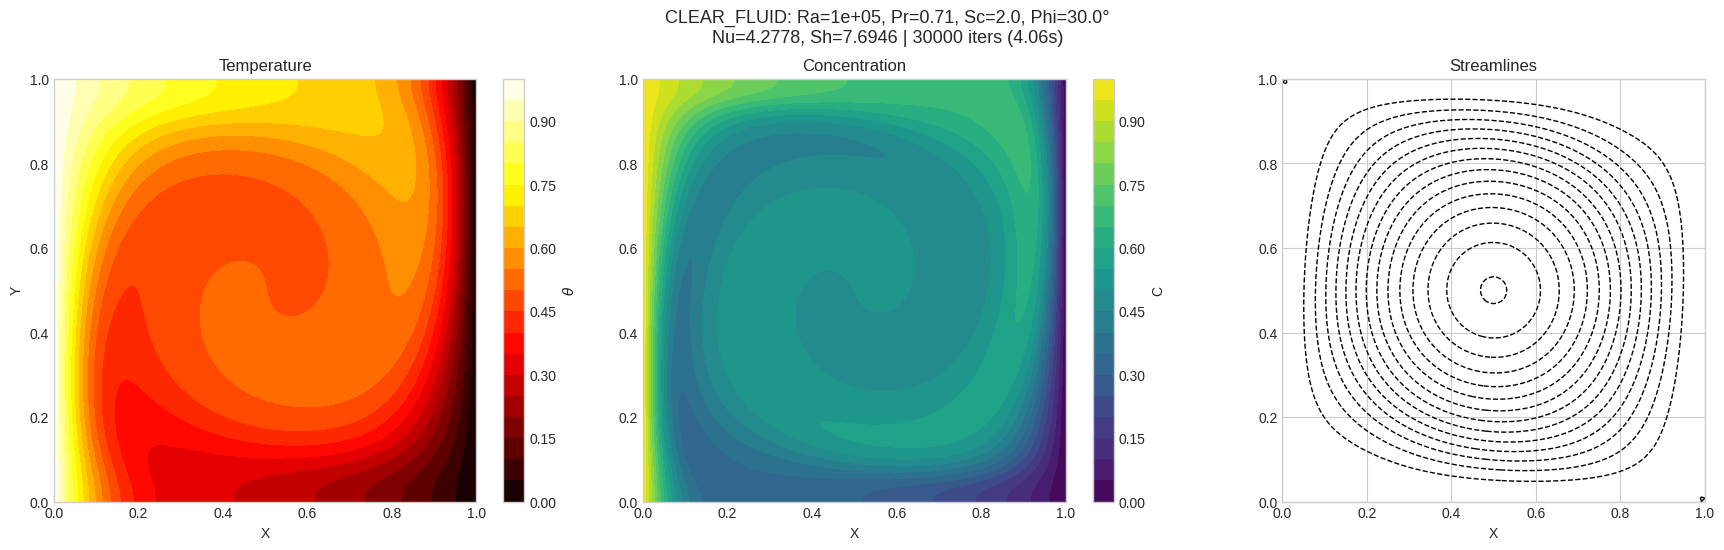

In [16]:
# --- Run Configuration ---
MODEL_TYPE = 'CLEAR_FLUID'
NX = 121
NY = 121
A = 1.0        # Aspect Ratio
RA = 1e5       # Rayleigh Number
PR = 0.71      # Prandtl
SC = 2.0       # Schmidt
SR = 0.5       # Soret
PHI_DEG = 30.0 # Angle (90 = vertical heated wall)
TOLERANCE = 1e-6
MAX_ITER = 30000
OMEGA_SOR = 0.15 # Relaxation parameter
PLOT_RESULTS = True

def main():
    # 1. Pack configuration into a single dictionary
    config = {
        'model_type': MODEL_TYPE, 
        'nx': NX, 'ny': NY, 'a': A,
        'ra': RA, 'pr': PR, 'sc': SC, 'sr': SR,
        'phi_deg': PHI_DEG,
        'omega_sor': OMEGA_SOR, 
        'tol': TOLERANCE, 'max_iter': MAX_ITER,
        'bc_type': 'adiabatic' # Options: 'adiabatic' or 'linear'
    }

    print(f"--- Running {MODEL_TYPE} Simulation ---")
    
    # 2. Call the Main Solver (uses the consolidated logic from previous step)
    result = main_solver(config)
    
    # Extract metrics for printing
    nu = result['nu_avg']
    sh = result['sh_avg']
    iters = result['iter_count'] # Note: key is 'iter_count', not 'iters'
    runtime = result['runtime']
    
    print(f"Done! Runtime: {runtime:.4f}s | Iterations: {iters}")
    print(f"Final Metrics: Nu_avg={nu:.4f}, Sh_avg={sh:.4f}")
    
    # 3. Visualize
    if PLOT_RESULTS:
        # Reconstruct y-array (since solver only returns x to save memory)
        y_coords = np.linspace(0, config['a'], config['ny'])
        
        plot_final_results(
            result['psi'], 
            result['theta'], 
            result['C'], 
            result['X'], # Note: key is 'X' (1D array)
            y_coords, 
            config, 
            nu, sh, runtime, iters
        )

if __name__ == '__main__':
    main()

## Interactive Campaign Runner (Visual Inspection)

This section implements an **Interactive Batch Runner**. It automates the process of running multiple test cases but focuses on **visual verification** rather than data export.

### **How it works**
1.  **Defined Campaigns:** The `test_campaigns` list defines several physical scenarios to investigate:
    * **Angle Variation:** How tilting the cavity (0° to 90°) affects flow and heat transfer.
    * **Rayleigh Scaling:** Testing standard $Ra$ values ($10^3$ to $10^5$) with different boundary conditions.
    * **High Aspect Ratio:** Testing a tall cavity ($AR=5$) where multicellular flow patterns often emerge.


Compiling Numba Functions (Wait 2-5 seconds)...

--- CAMPAIGN: Clear_Fluid_Vary_Angle_Ra100k (6 cases) ---
Running Case 1/6: Ra=1e+05, Angle=0°, AR=1, BC=linear
Running Case 1: Ra=1e+05, Omega=0.15
  -> Done in 0.07s (500 iters). Nu=1.0000, Sh=1.0000
  -> Displaying plot. Close window to continue...


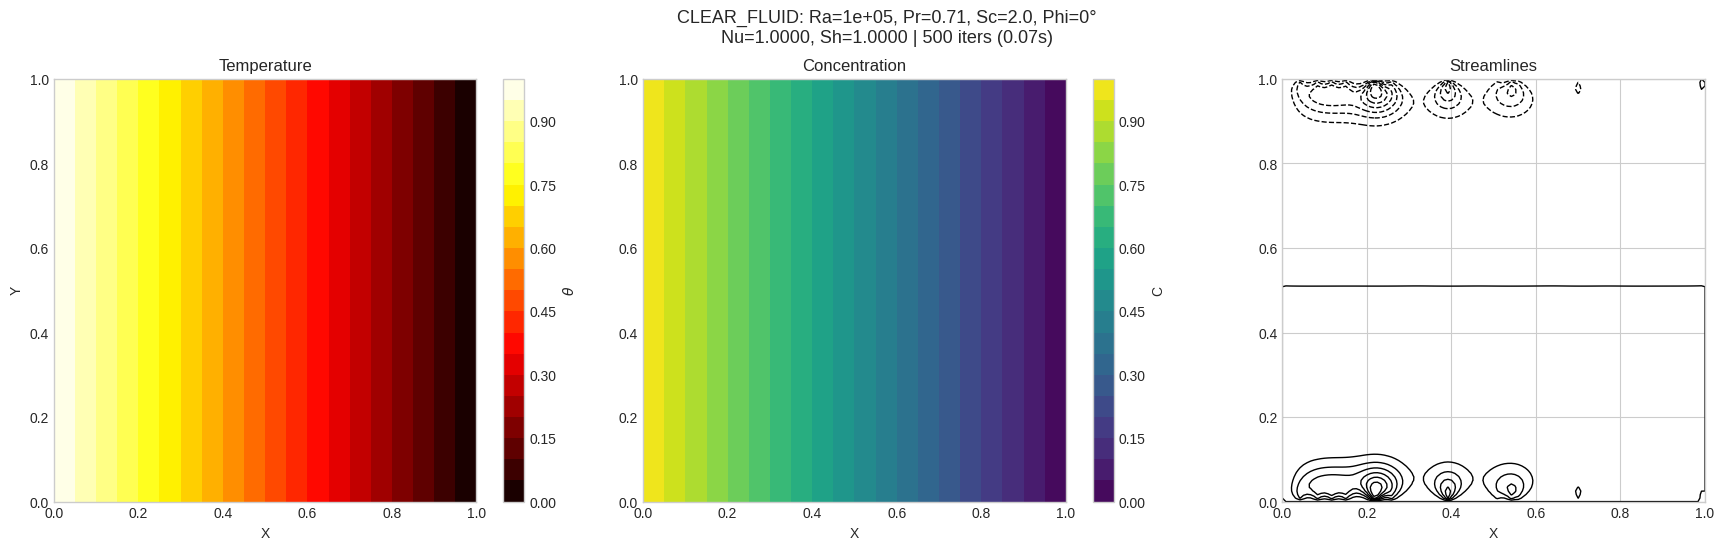

Running Case 2/6: Ra=1e+05, Angle=30°, AR=1, BC=linear
Running Case 2: Ra=1e+05, Omega=0.15
  -> Done in 4.00s (30000 iters). Nu=3.2428, Sh=5.8250
  -> Displaying plot. Close window to continue...


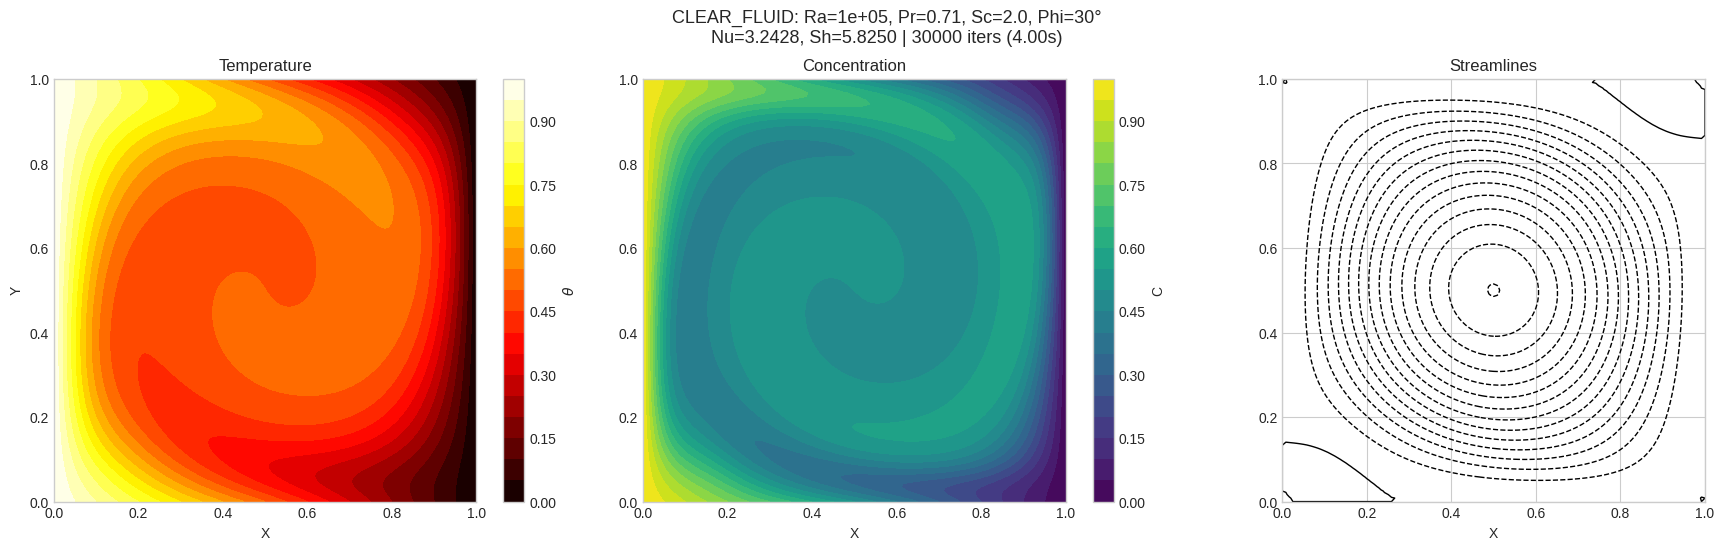

Running Case 3/6: Ra=1e+05, Angle=45°, AR=1, BC=linear
Running Case 3: Ra=1e+05, Omega=0.15
  -> Done in 4.05s (30000 iters). Nu=3.2832, Sh=5.9706
  -> Displaying plot. Close window to continue...


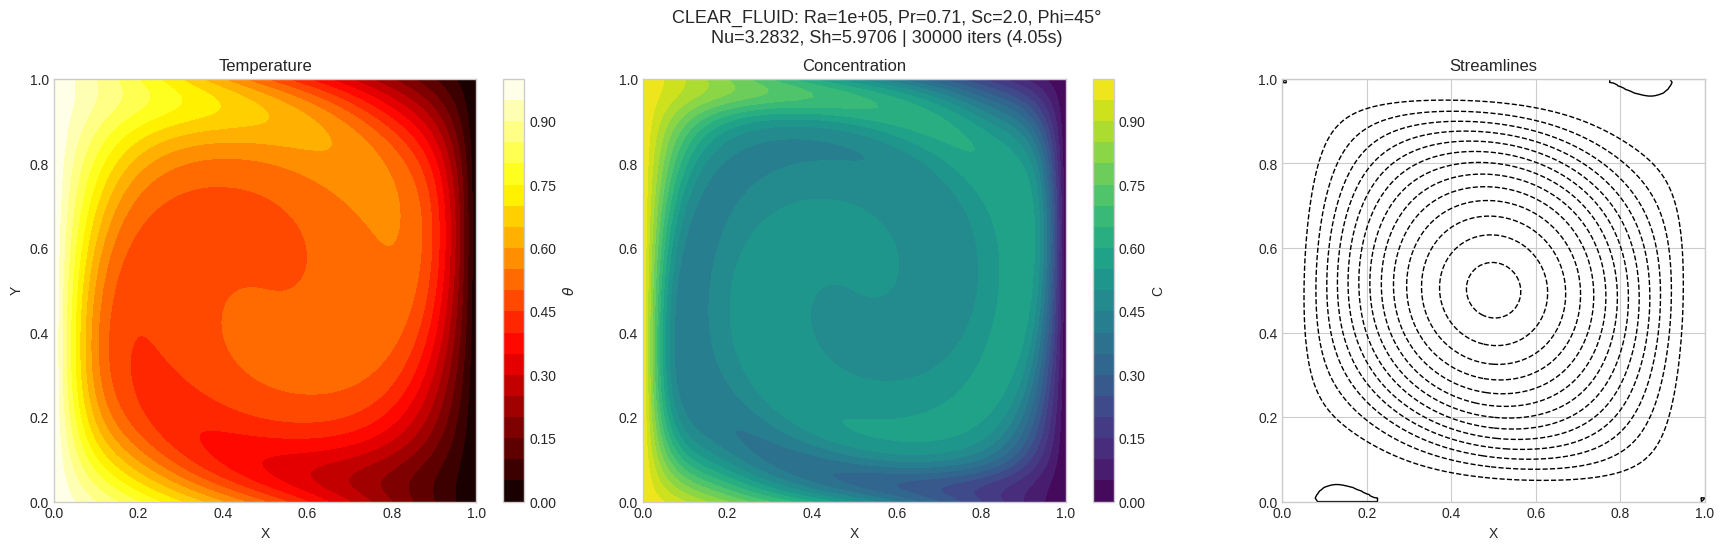

Running Case 4/6: Ra=1e+05, Angle=60°, AR=1, BC=linear
Running Case 4: Ra=1e+05, Omega=0.15
  -> Done in 4.06s (30000 iters). Nu=3.2961, Sh=6.0813
  -> Displaying plot. Close window to continue...


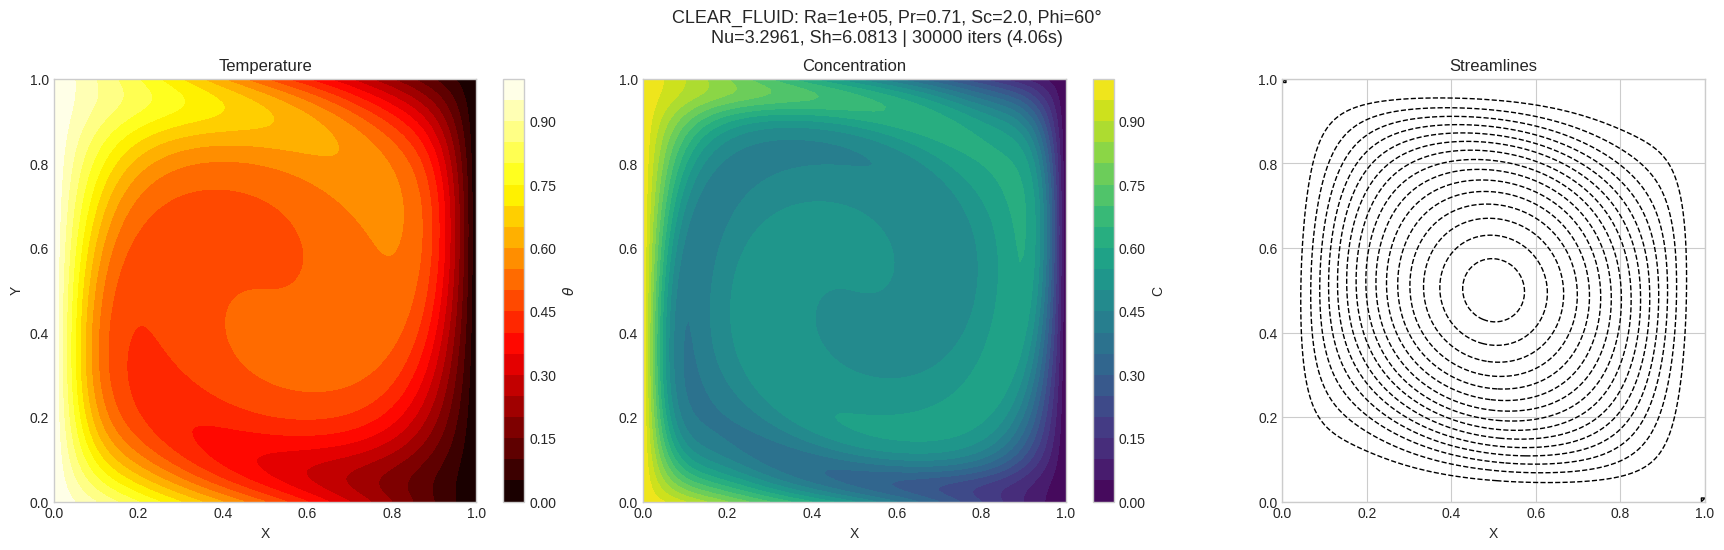

Running Case 5/6: Ra=1e+05, Angle=75°, AR=1, BC=linear
Running Case 5: Ra=1e+05, Omega=0.15
  -> Done in 4.11s (30000 iters). Nu=3.2604, Sh=6.1220
  -> Displaying plot. Close window to continue...


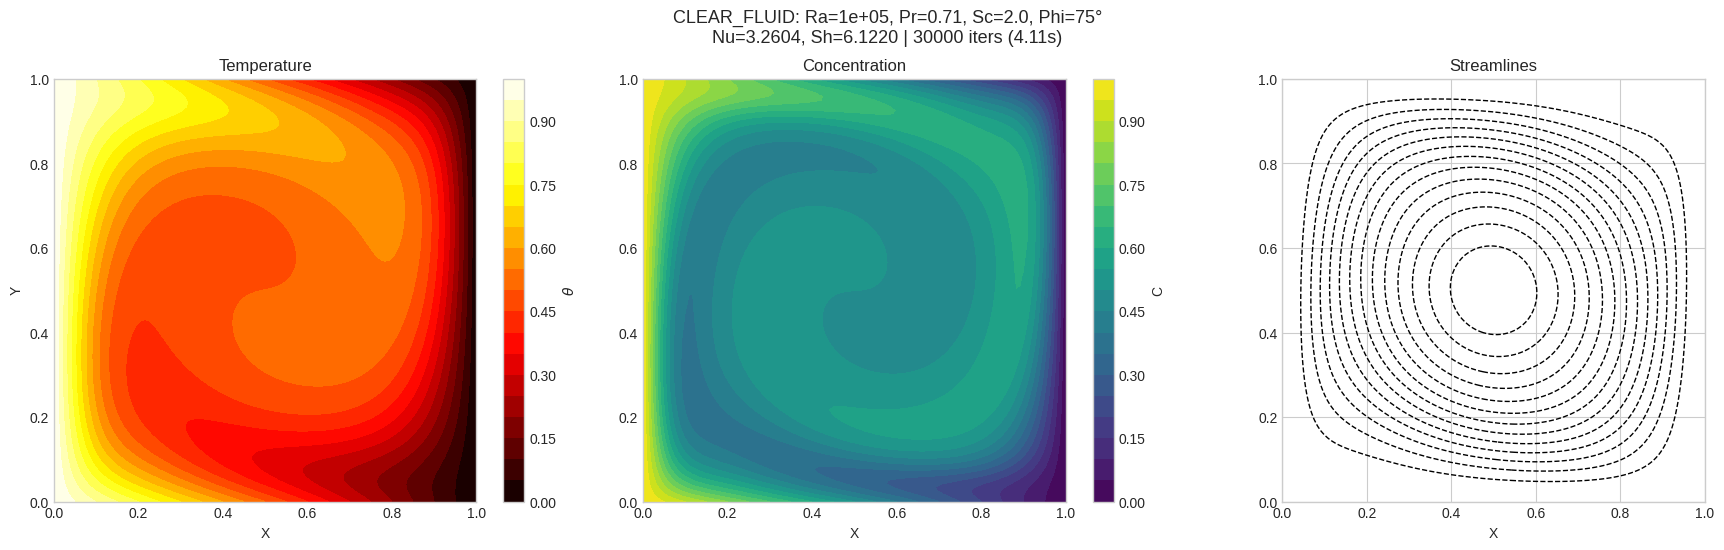

Running Case 6/6: Ra=1e+05, Angle=90°, AR=1, BC=linear
Running Case 6: Ra=1e+05, Omega=0.15
  -> Done in 4.04s (30000 iters). Nu=3.1668, Sh=6.0734
  -> Displaying plot. Close window to continue...


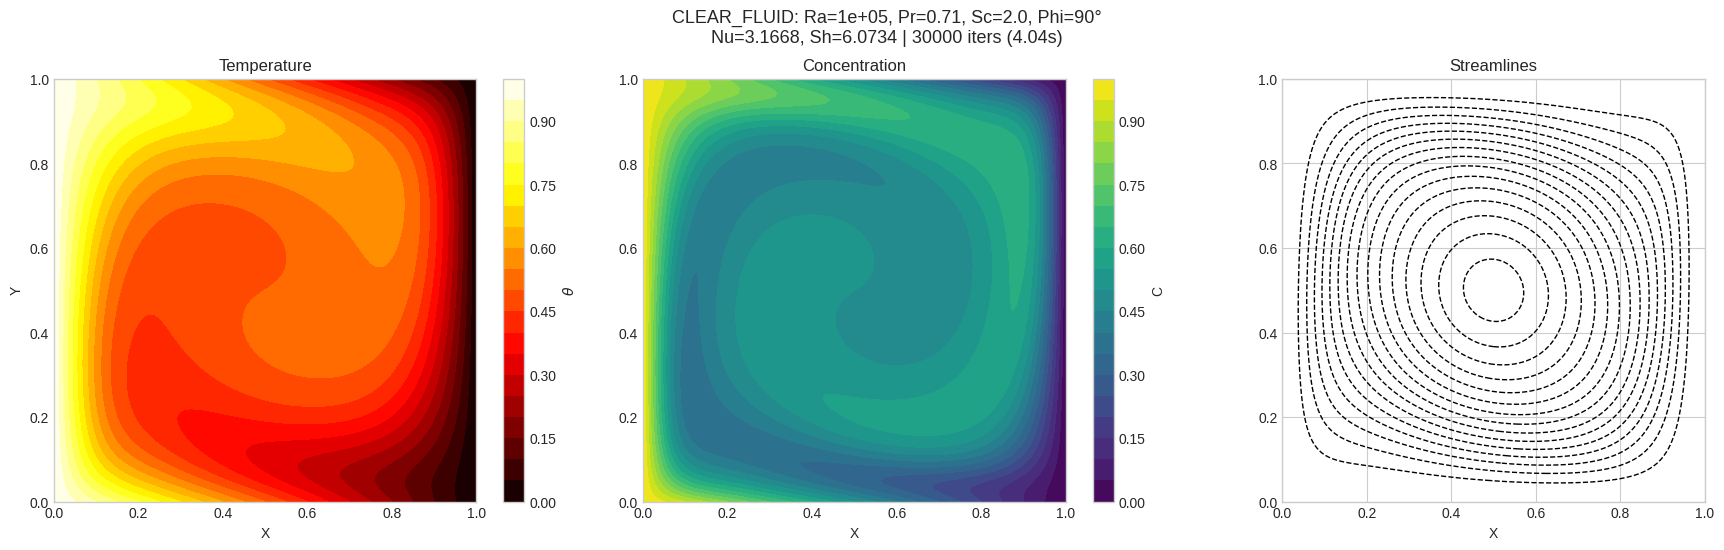


--- CAMPAIGN: Clear_Fluid_Vary_Ra_Adiabatic (6 cases) ---
Running Case 1/6: Ra=1e+02, Angle=45°, AR=1, BC=adiabatic
Running Case 1: Ra=1e+02, Omega=0.15
  -> Done in 0.07s (500 iters). Nu=1.0000, Sh=1.0000
  -> Displaying plot. Close window to continue...


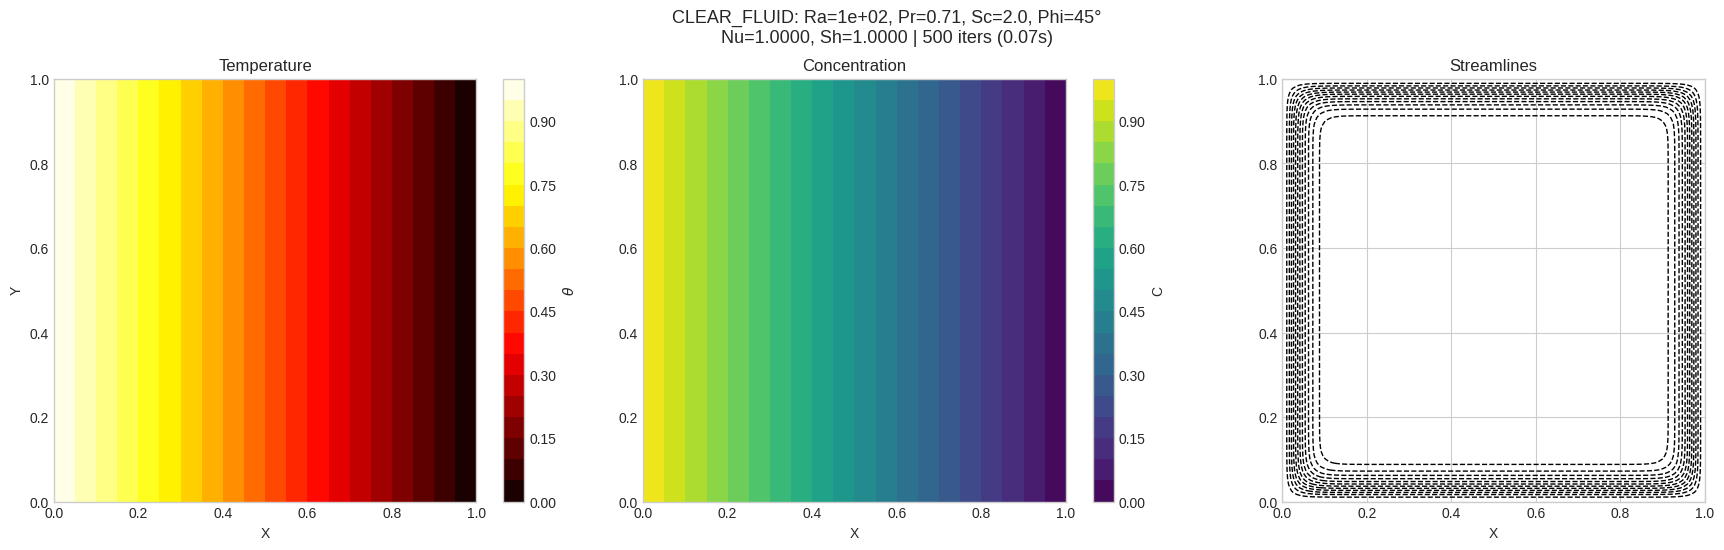

Running Case 2/6: Ra=1e+02, Angle=90°, AR=1, BC=adiabatic
Running Case 2: Ra=1e+02, Omega=0.15
  -> Done in 0.07s (500 iters). Nu=1.0000, Sh=1.0000
  -> Displaying plot. Close window to continue...


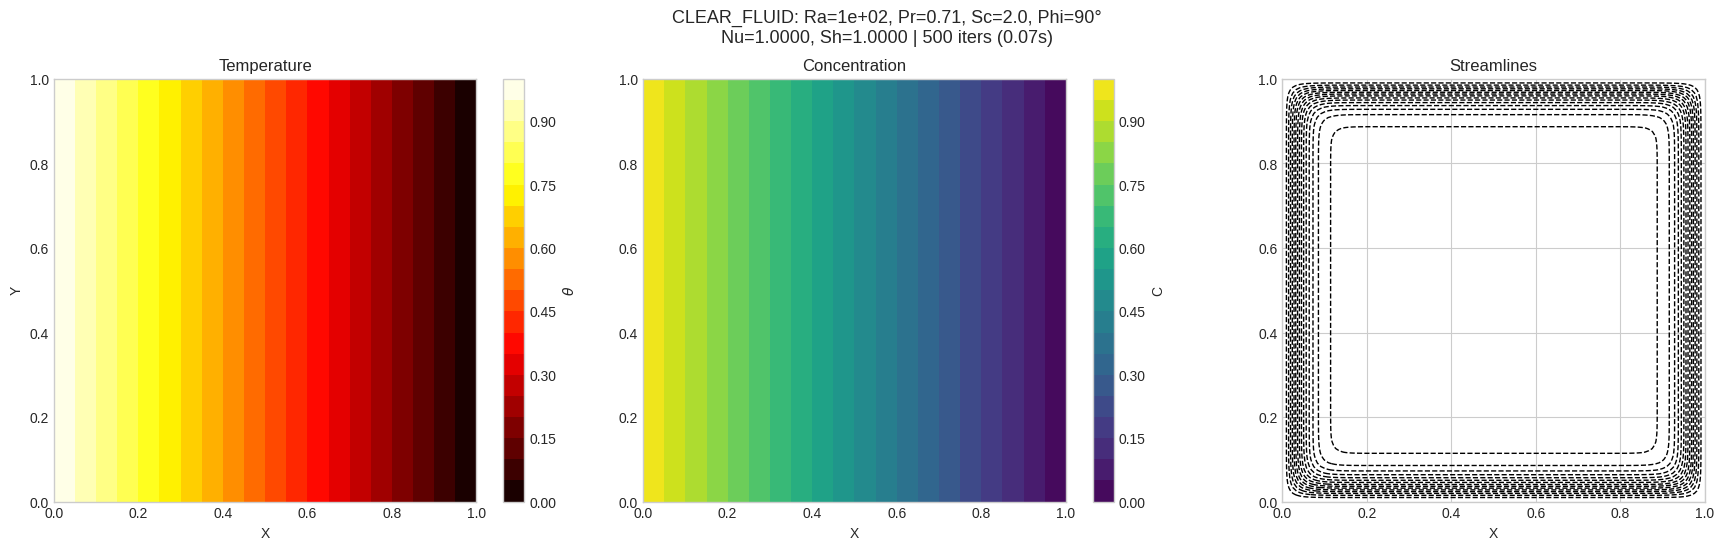

Running Case 3/6: Ra=1e+03, Angle=45°, AR=1, BC=adiabatic
Running Case 3: Ra=1e+03, Omega=0.15
  -> Done in 4.04s (30000 iters). Nu=1.0189, Sh=1.1795
  -> Displaying plot. Close window to continue...


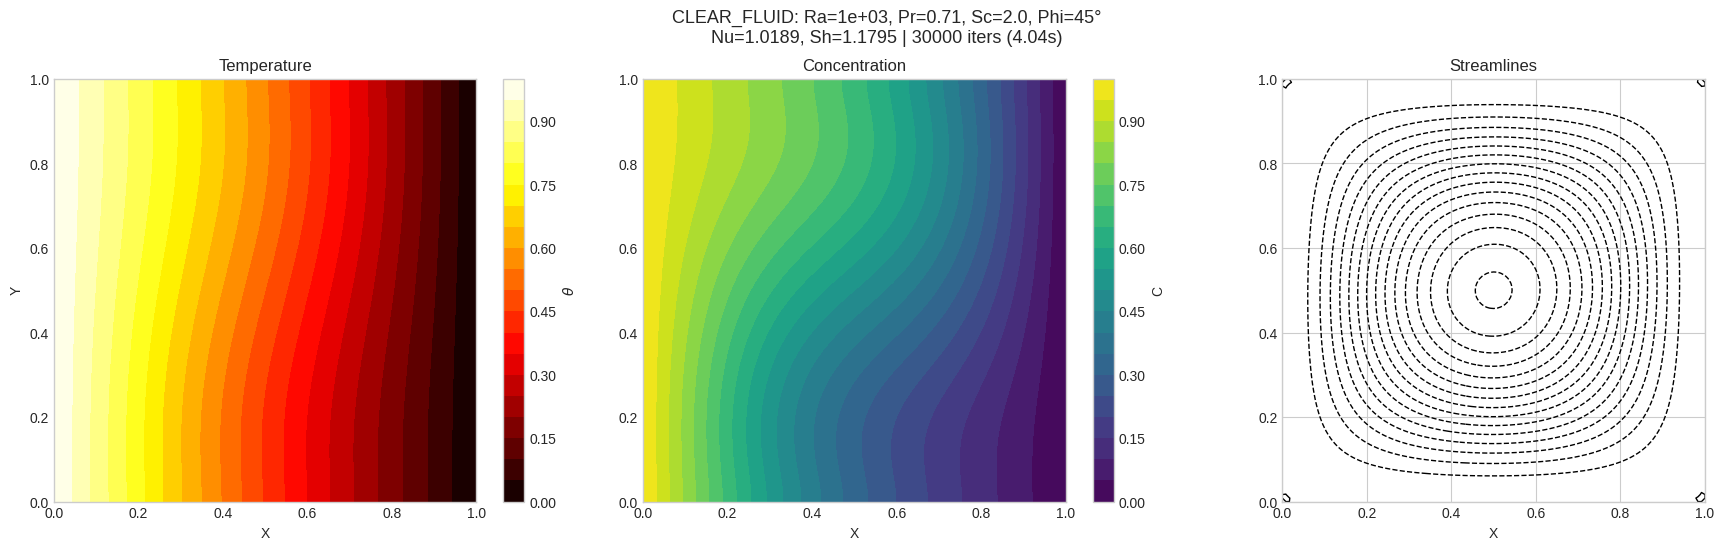

Running Case 4/6: Ra=1e+03, Angle=90°, AR=1, BC=adiabatic
Running Case 4: Ra=1e+03, Omega=0.15
  -> Done in 4.07s (30000 iters). Nu=1.0358, Sh=1.3343
  -> Displaying plot. Close window to continue...


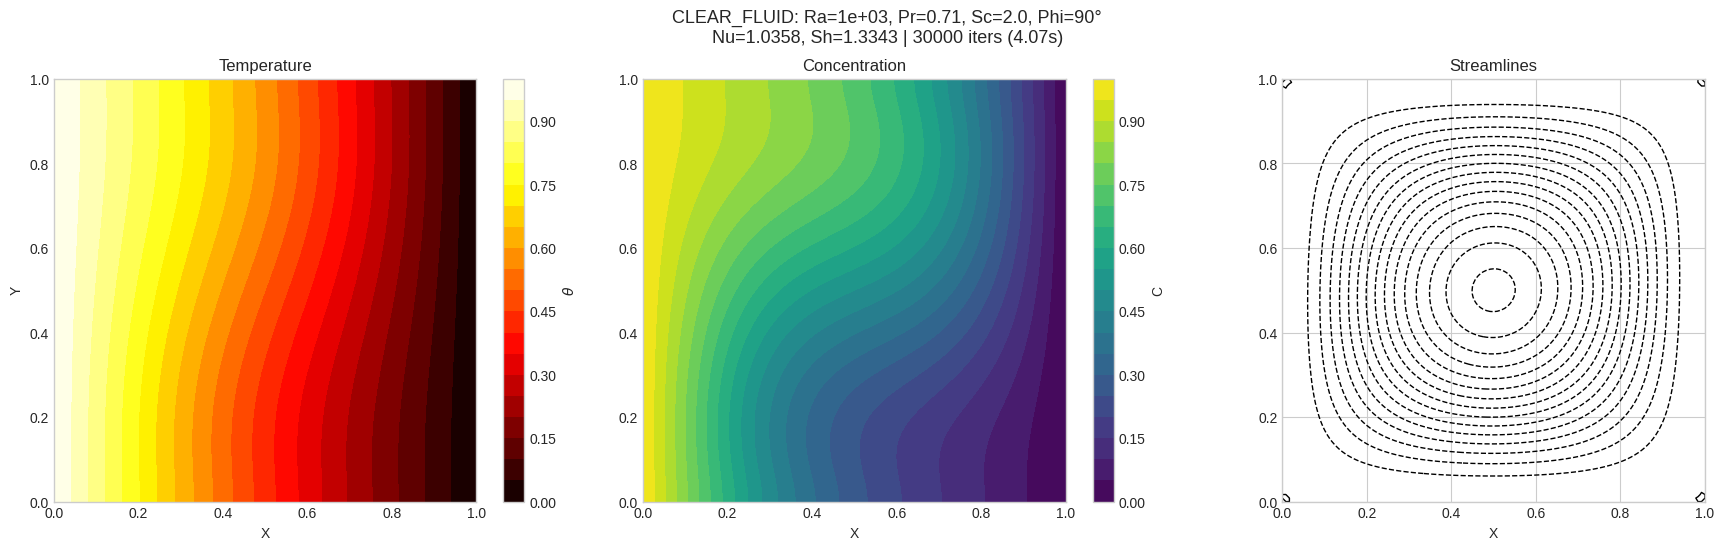

Running Case 5/6: Ra=1e+04, Angle=45°, AR=1, BC=adiabatic
Running Case 5: Ra=1e+04, Omega=0.15
  -> Done in 4.10s (30000 iters). Nu=2.6817, Sh=4.8029
  -> Displaying plot. Close window to continue...


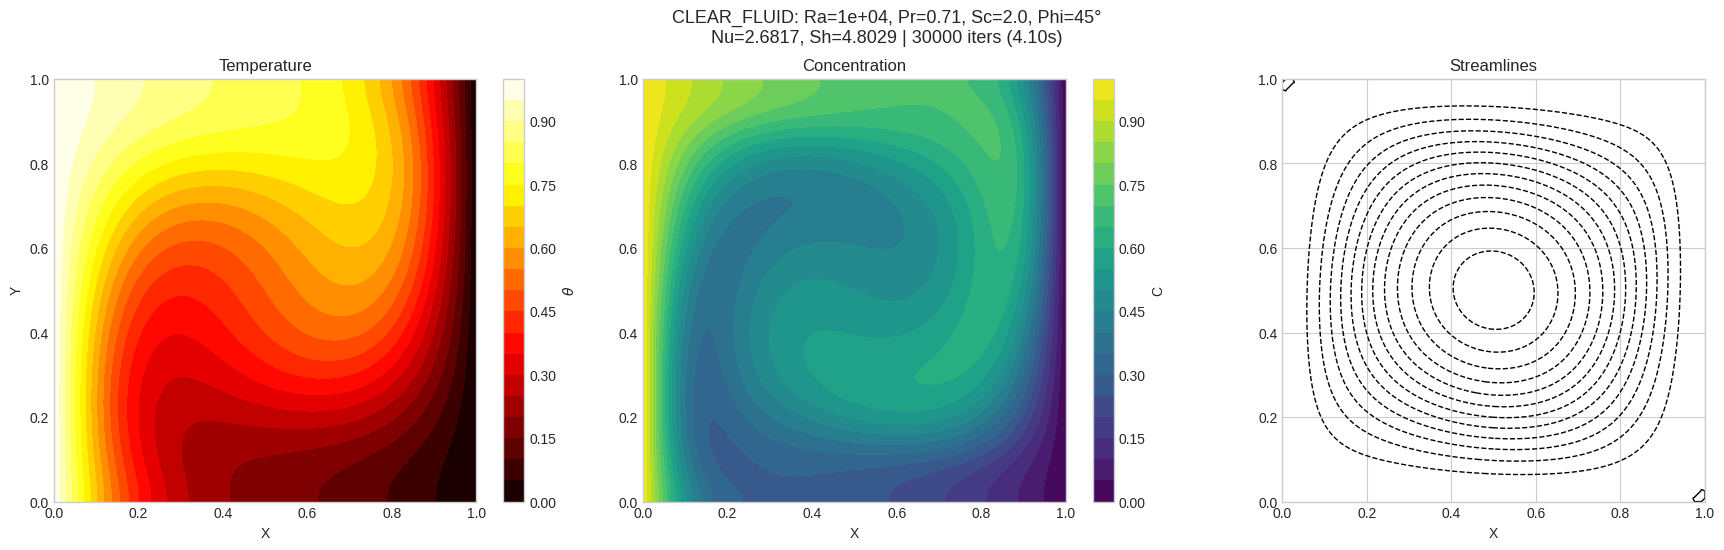

Running Case 6/6: Ra=1e+04, Angle=90°, AR=1, BC=adiabatic
Running Case 6: Ra=1e+04, Omega=0.15
  -> Done in 4.01s (30000 iters). Nu=2.7740, Sh=4.9160
  -> Displaying plot. Close window to continue...


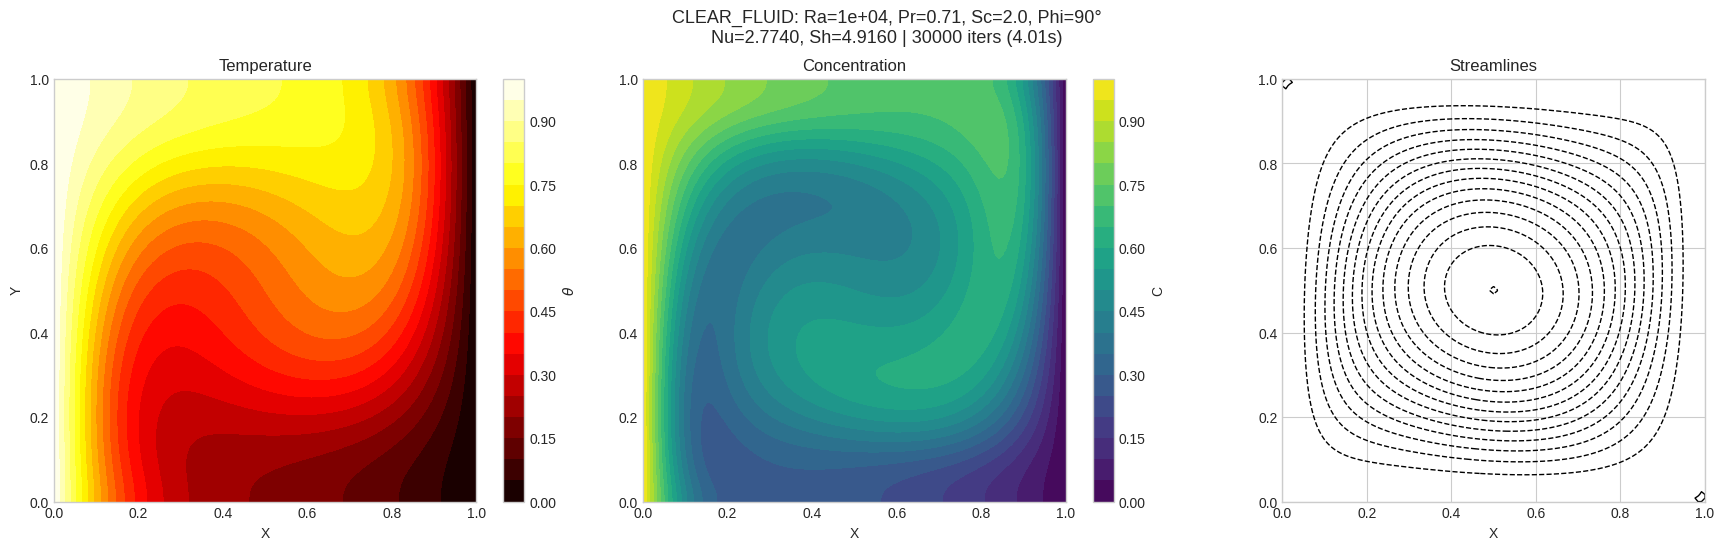


--- CAMPAIGN: Clear_Fluid_Vary_Ra_Linear (8 cases) ---
Running Case 1/8: Ra=1e+02, Angle=45°, AR=1, BC=linear
Running Case 1: Ra=1e+02, Omega=0.15
  -> Done in 0.07s (500 iters). Nu=1.0000, Sh=1.0000
  -> Displaying plot. Close window to continue...


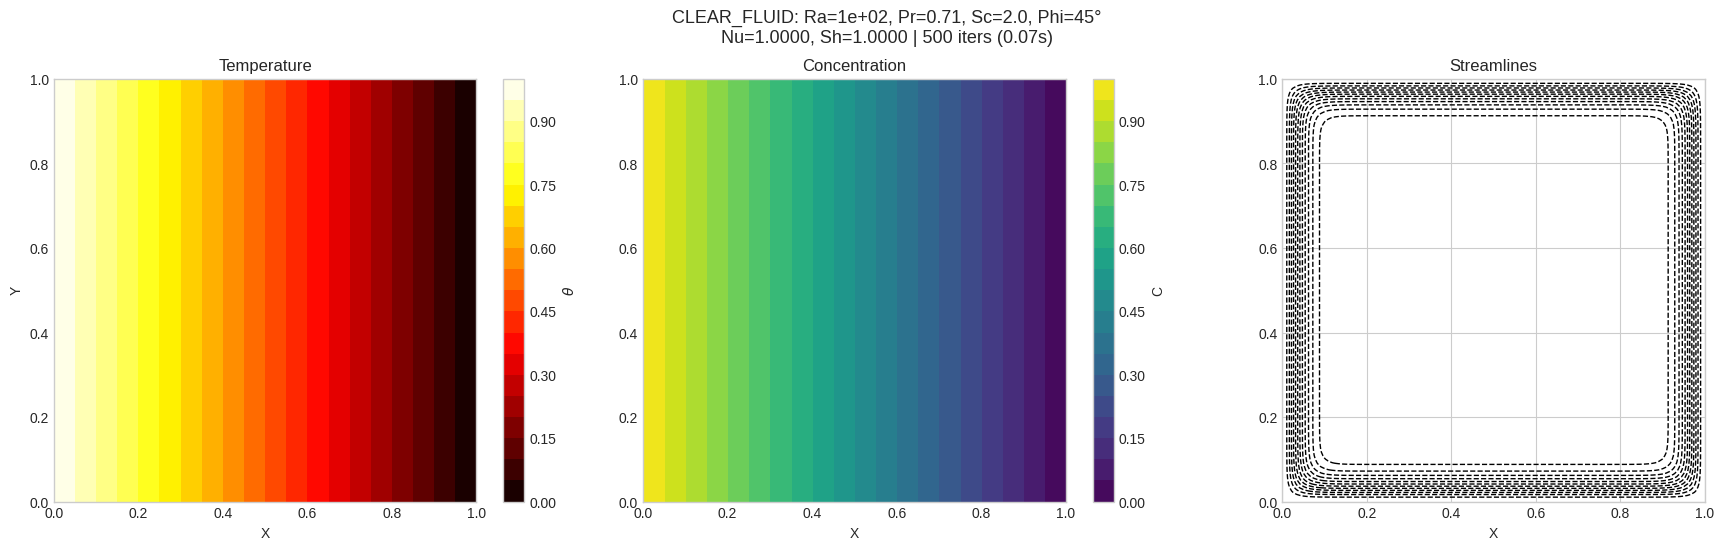

Running Case 2/8: Ra=1e+02, Angle=90°, AR=1, BC=linear
Running Case 2: Ra=1e+02, Omega=0.15
  -> Done in 0.07s (500 iters). Nu=1.0000, Sh=1.0000
  -> Displaying plot. Close window to continue...


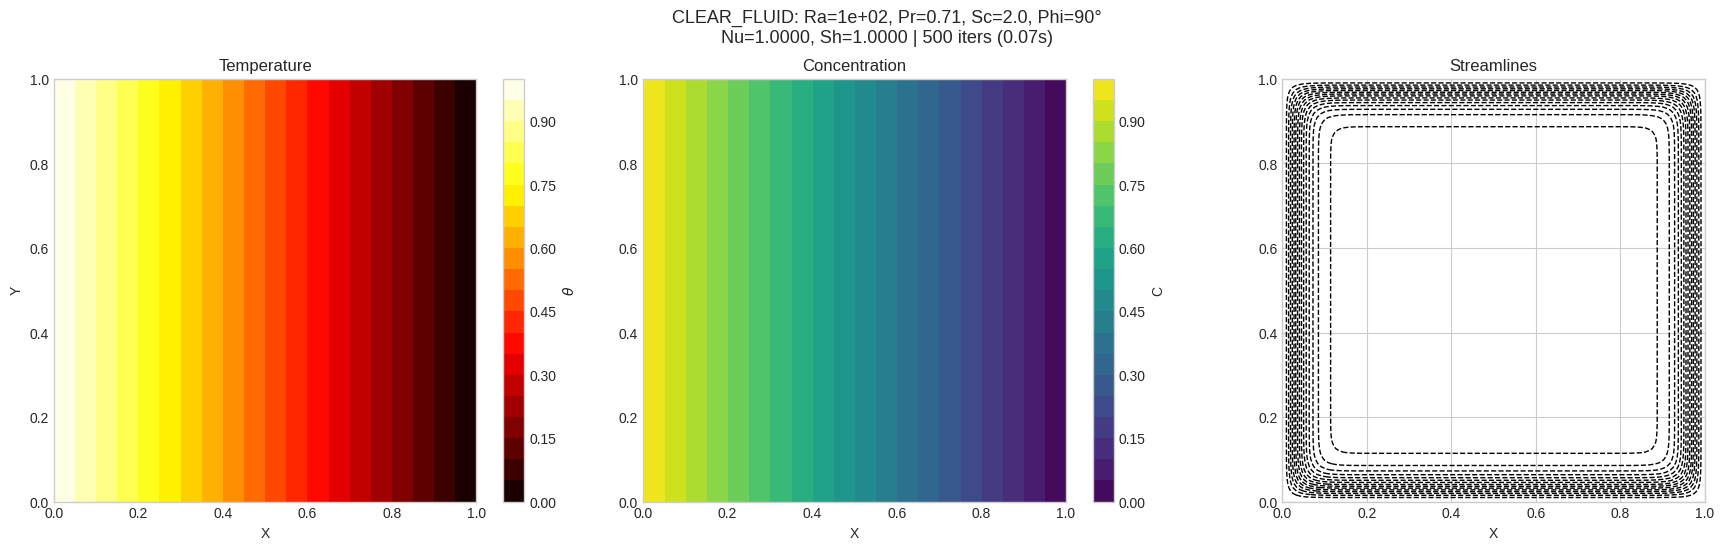

Running Case 3/8: Ra=1e+03, Angle=45°, AR=1, BC=linear
Running Case 3: Ra=1e+03, Omega=0.15
  -> Done in 4.27s (30000 iters). Nu=1.0110, Sh=1.1176
  -> Displaying plot. Close window to continue...


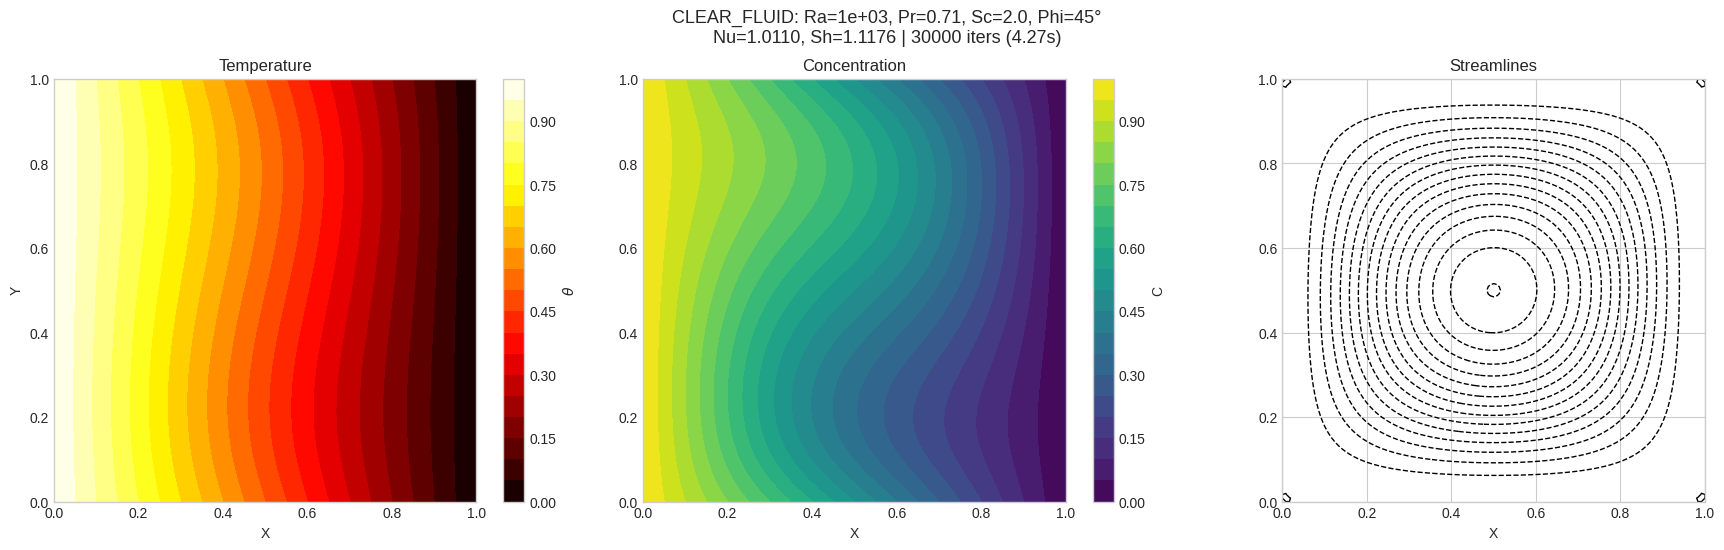

Running Case 4/8: Ra=1e+03, Angle=90°, AR=1, BC=linear
Running Case 4: Ra=1e+03, Omega=0.15
  -> Done in 4.28s (30000 iters). Nu=1.0208, Sh=1.2185
  -> Displaying plot. Close window to continue...


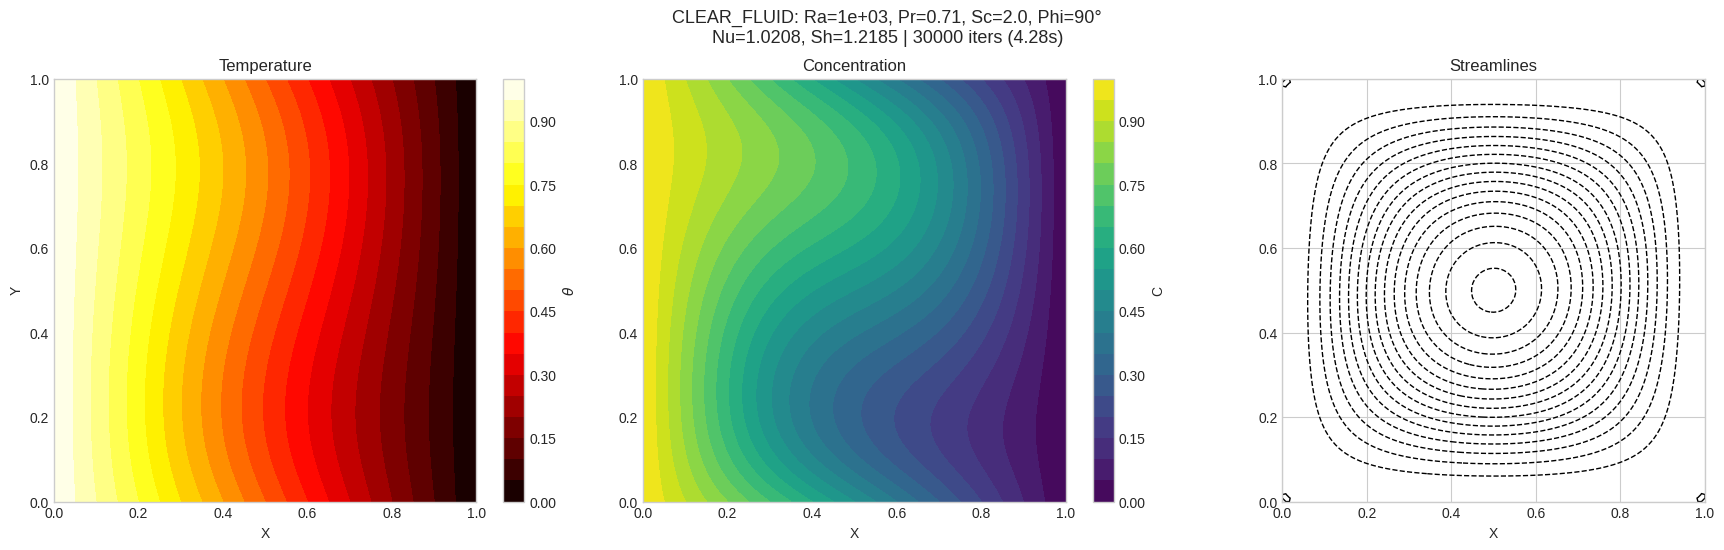

Running Case 5/8: Ra=1e+04, Angle=45°, AR=1, BC=linear
Running Case 5: Ra=1e+04, Omega=0.15
  -> Done in 4.16s (30000 iters). Nu=1.9550, Sh=3.5310
  -> Displaying plot. Close window to continue...


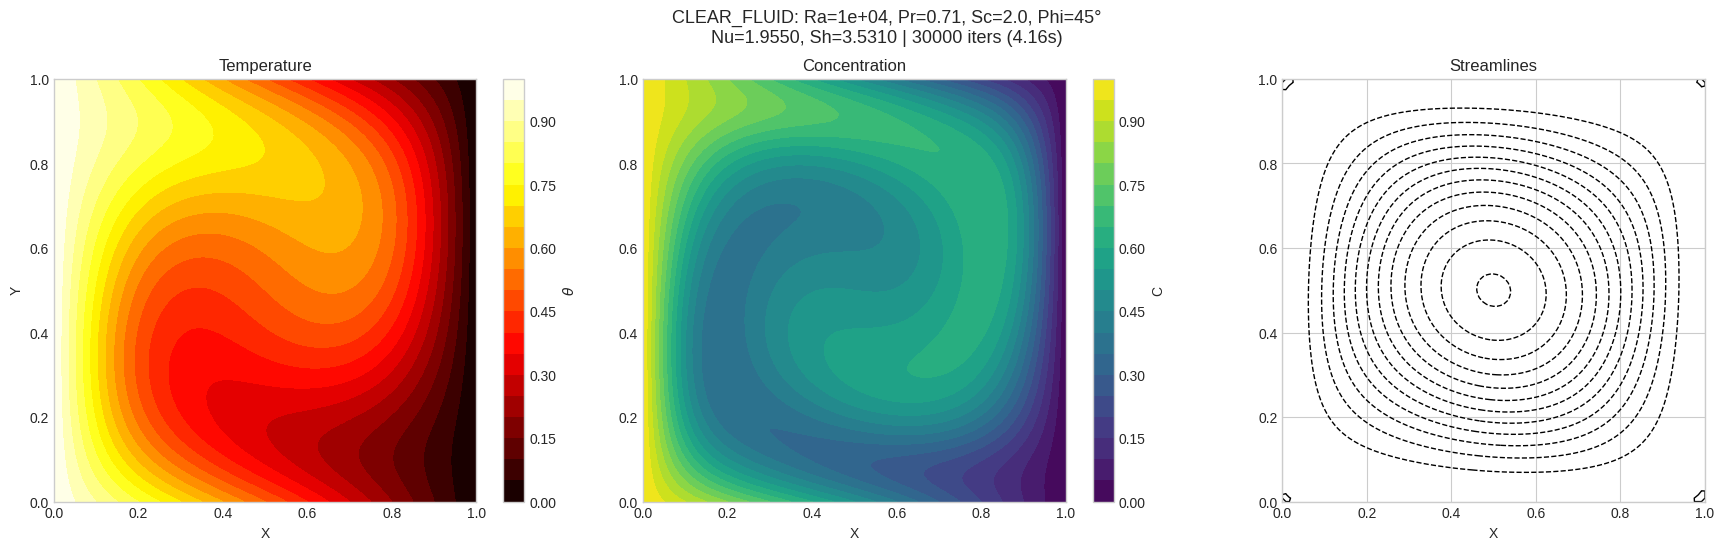

Running Case 6/8: Ra=1e+04, Angle=90°, AR=1, BC=linear
Running Case 6: Ra=1e+04, Omega=0.15
  -> Done in 4.13s (30000 iters). Nu=2.0323, Sh=3.6840
  -> Displaying plot. Close window to continue...


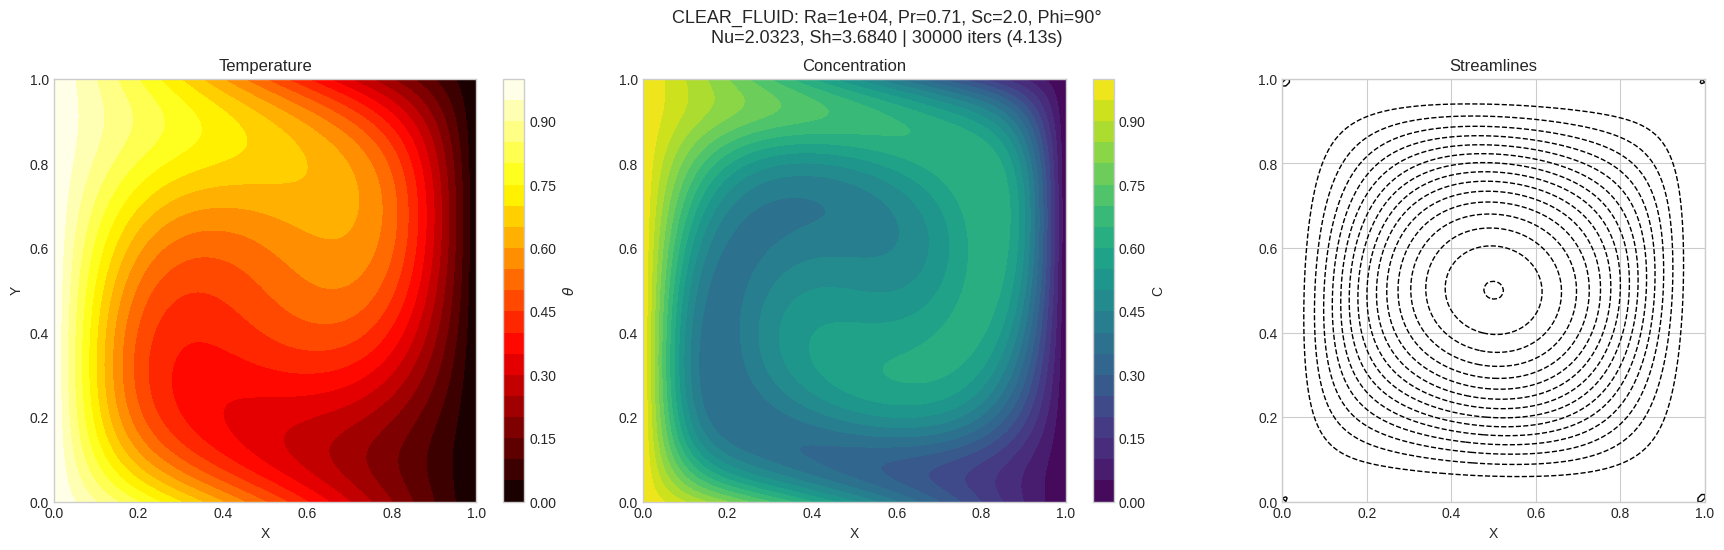

Running Case 7/8: Ra=1e+05, Angle=45°, AR=1, BC=linear
Running Case 7: Ra=1e+05, Omega=0.15
  -> Done in 4.09s (30000 iters). Nu=3.2832, Sh=5.9706
  -> Displaying plot. Close window to continue...


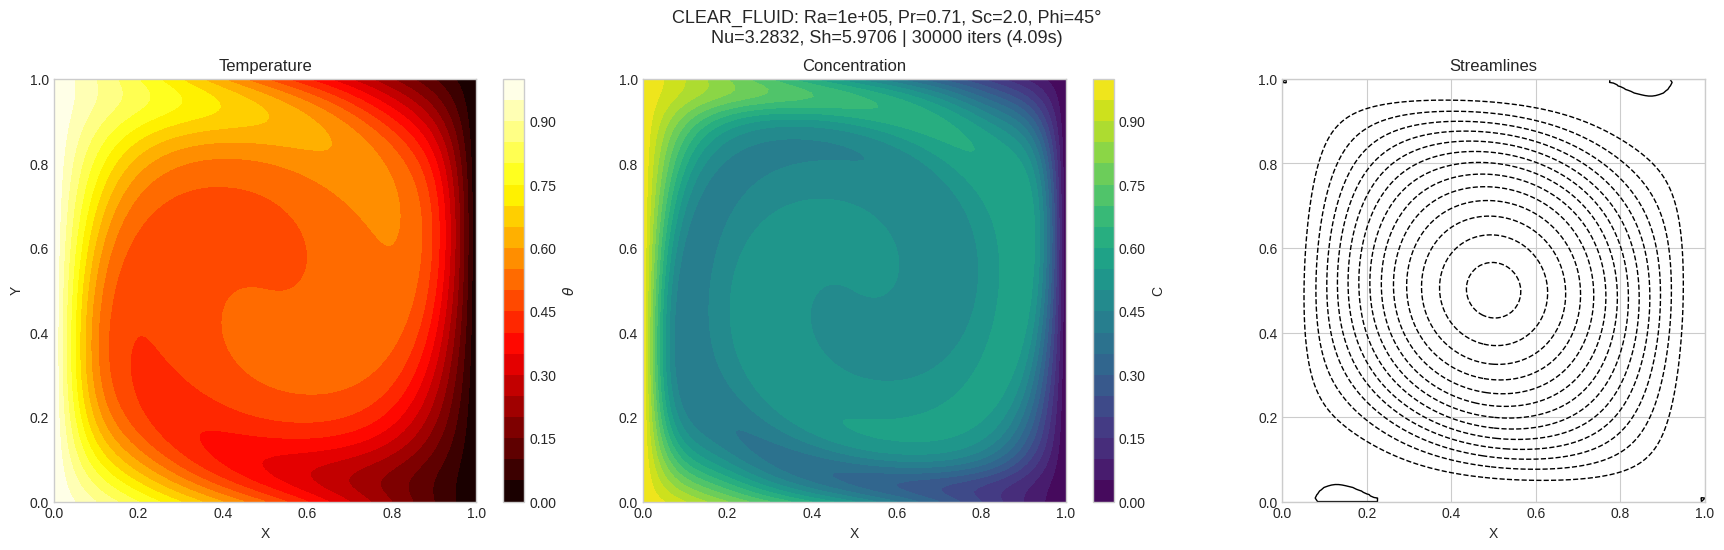

Running Case 8/8: Ra=1e+05, Angle=90°, AR=1, BC=linear
Running Case 8: Ra=1e+05, Omega=0.15
  -> Done in 4.09s (30000 iters). Nu=3.1668, Sh=6.0734
  -> Displaying plot. Close window to continue...


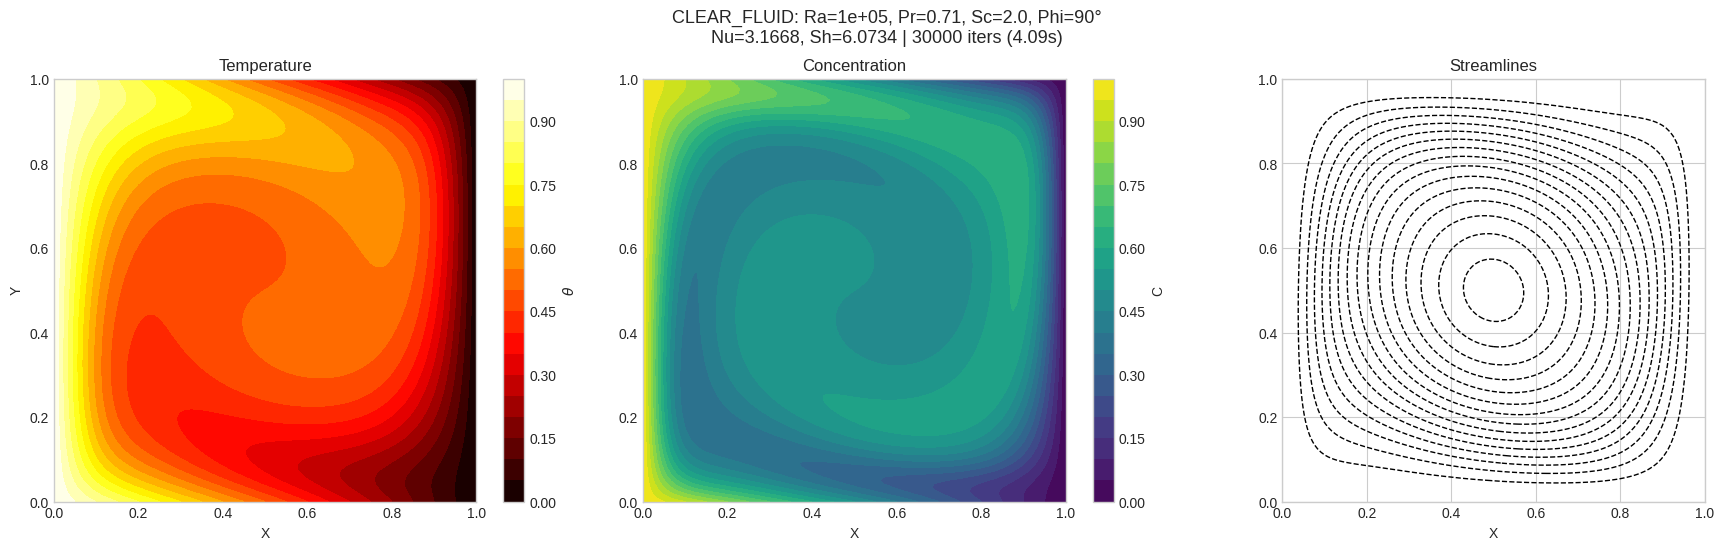


--- CAMPAIGN: Clear_Fluid_Vary_Ra_AR50 (2 cases) ---
Running Case 1/2: Ra=2e+03, Angle=0°, AR=5, BC=linear
Running Case 1: Ra=2e+03, Omega=0.15
  -> Done in 0.07s (500 iters). Nu=1.0000, Sh=1.0000
  -> Displaying plot. Close window to continue...


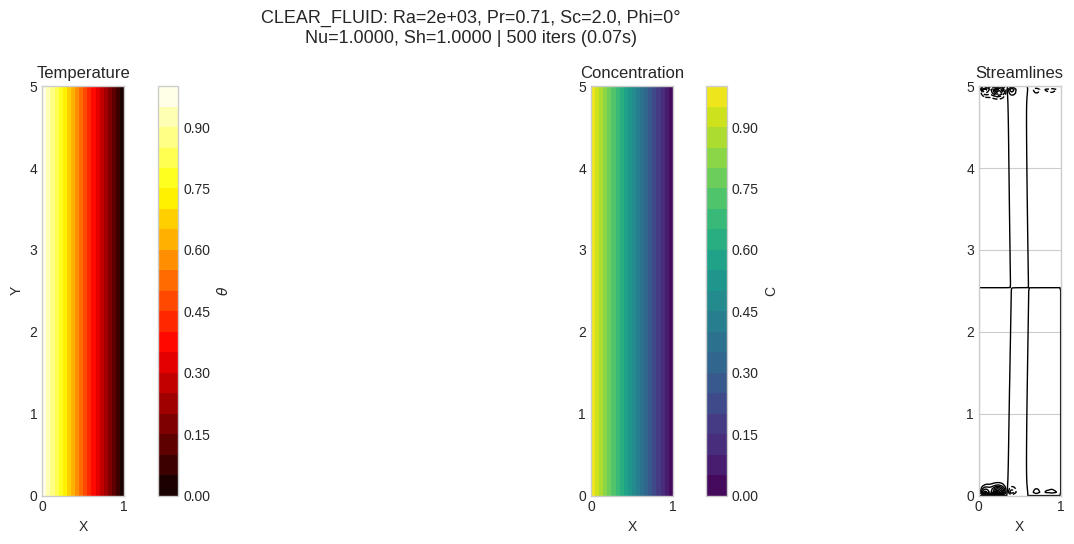

Running Case 2/2: Ra=2e+04, Angle=0°, AR=5, BC=linear
Running Case 2: Ra=2e+04, Omega=0.15
  -> Done in 0.07s (500 iters). Nu=1.0000, Sh=1.0000
  -> Displaying plot. Close window to continue...


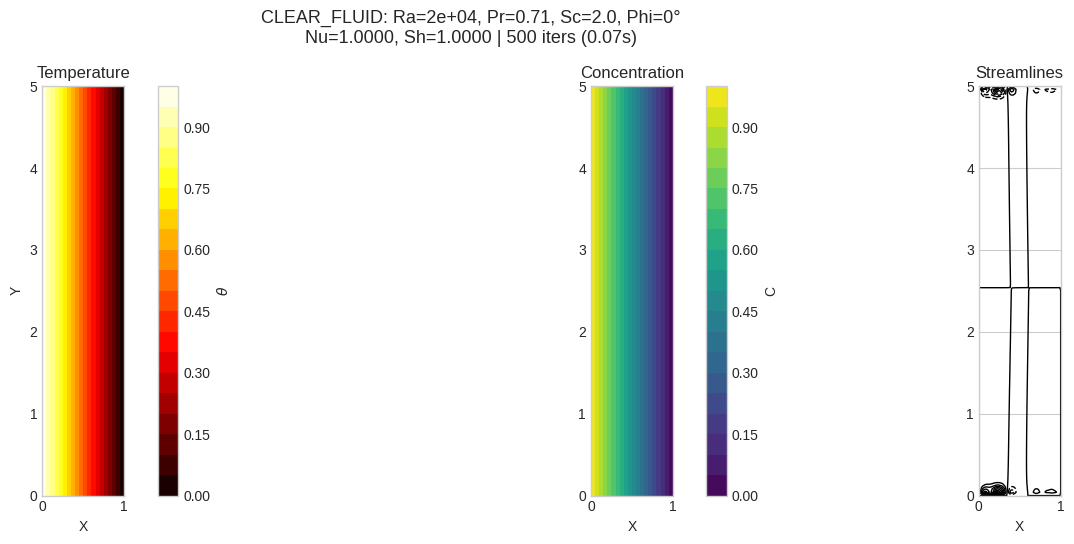


--- CAMPAIGN: Clear_Fluid_Vary_Ra_AR5 (4 cases) ---
Running Case 1/4: Ra=2e+03, Angle=45°, AR=5, BC=linear
Running Case 1: Ra=2e+03, Omega=0.15
  -> Done in 4.13s (30000 iters). Nu=1.0469, Sh=1.4170
  -> Displaying plot. Close window to continue...


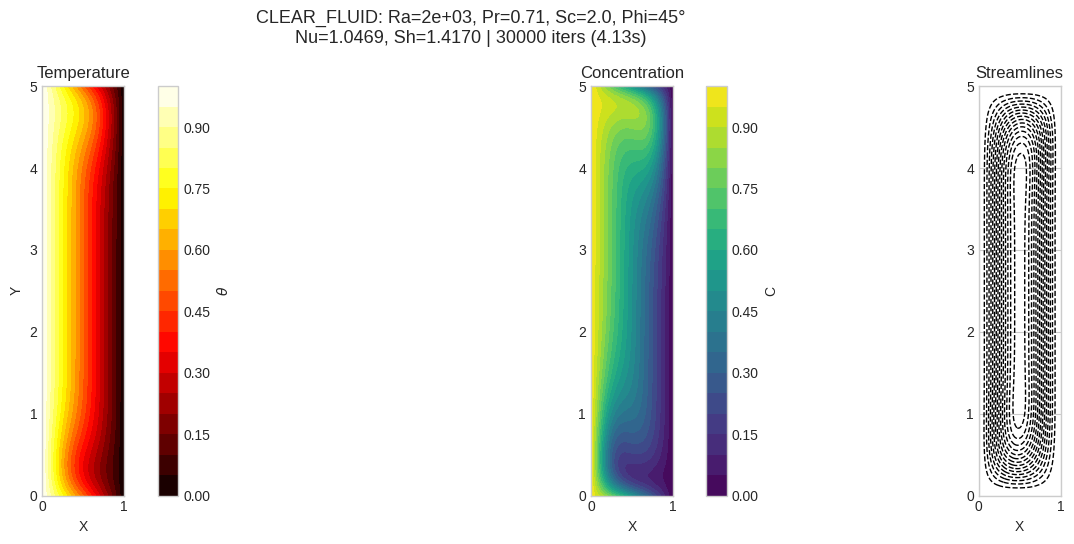

Running Case 2/4: Ra=2e+03, Angle=45°, AR=5, BC=linear
Running Case 2: Ra=2e+03, Omega=0.15
  -> Done in 4.24s (30000 iters). Nu=1.0670, Sh=1.5536
  -> Displaying plot. Close window to continue...


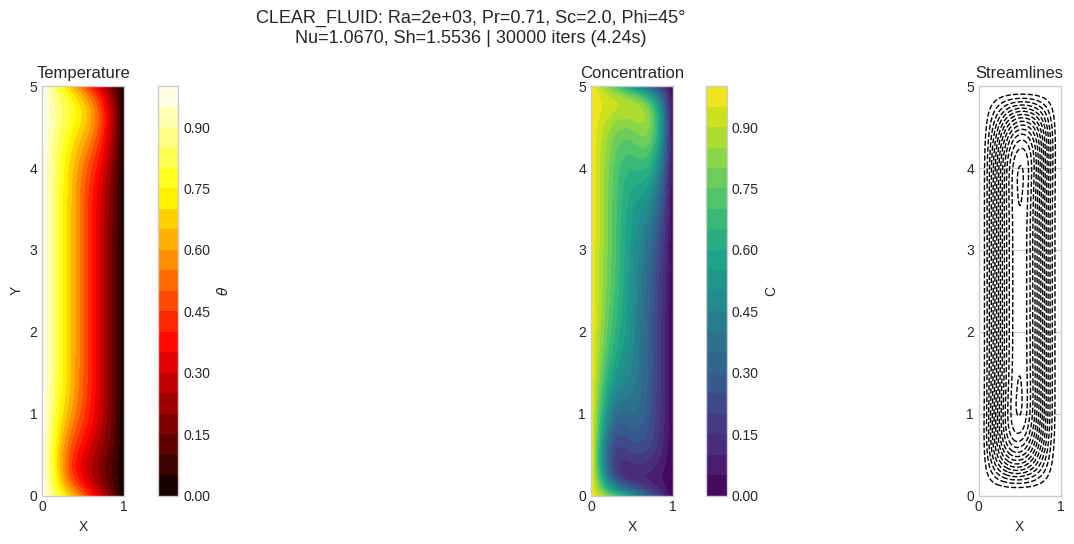

Running Case 3/4: Ra=2e+03, Angle=45°, AR=5, BC=linear
Running Case 3: Ra=2e+03, Omega=0.15
  -> Done in 4.07s (30000 iters). Nu=1.0822, Sh=1.6469
  -> Displaying plot. Close window to continue...


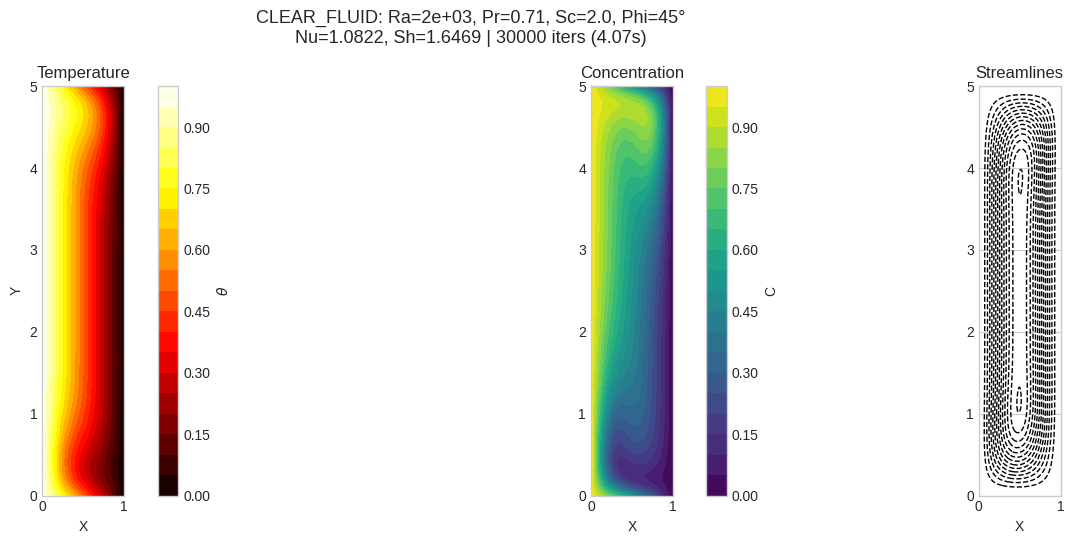

Running Case 4/4: Ra=2e+03, Angle=45°, AR=5, BC=linear
Running Case 4: Ra=2e+03, Omega=0.15
  -> Done in 4.19s (30000 iters). Nu=1.0985, Sh=1.7412
  -> Displaying plot. Close window to continue...


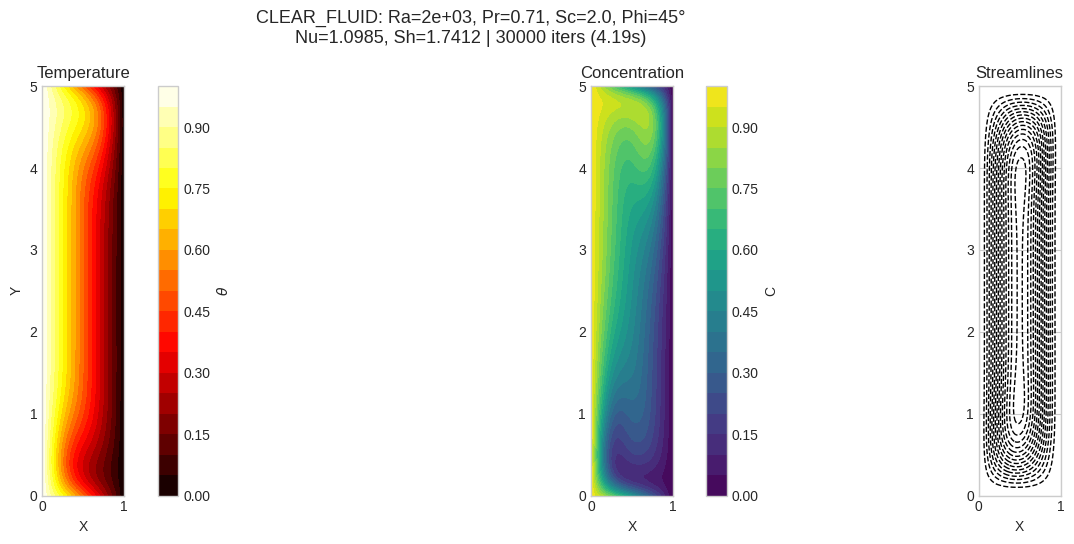


All campaigns finished.


In [17]:
# =============================================================================
# Global Settings
# =============================================================================
NX, NY = 121, 121
PR, SC, SR = 0.71, 2.0, 0.5
OMEGA_SOR, TOLERANCE, MAX_ITER = 0.15, 1e-6, 30000

def generate_test_cases(params_dict):
    keys = params_dict.keys()
    value_combinations = itertools.product(*params_dict.values())
    return [dict(zip(keys, combo)) for combo in value_combinations]

if __name__ == '__main__':
    # --- DEFINE CAMPAIGNS ---
    test_campaigns = [
        {
            'name': 'Clear_Fluid_Vary_Angle_Ra100k',
            'model': 'CLEAR_FLUID',
            'params': {'AR': [1], 'Ra': [100000], 'Angle': [0, 30, 45, 60, 75, 90], 'bc_type': ['linear']}
        },
        {
            'name': 'Clear_Fluid_Vary_Ra_Adiabatic',
            'model': 'CLEAR_FLUID',
            'params': {'AR': [1], 'Ra': [100, 1000, 10000], 'Angle': [45,90], 'bc_type': ['adiabatic']}
        },
        {
            'name': 'Clear_Fluid_Vary_Ra_Linear',
            'model': 'CLEAR_FLUID',
            'params': {'AR': [1], 'Ra': [100, 1000, 10000, 100000], 'Angle': [45,90], 'bc_type': ['linear']}
        },
           {
            'name': 'Clear_Fluid_Vary_Ra_AR50',
            'model': 'CLEAR_FLUID',
            'params': {'AR': [5], 'Ra': [ 1800, 18000 ], 'Angle': [0], 'bc_type': ['linear']}
        },
        {
            'name': 'Clear_Fluid_Vary_Ra_AR5',
            'model': 'CLEAR_FLUID',
            'params': {'AR': [5], 'Ra': [1500, 1800, 2000, 2200], 'Angle': [45], 'bc_type': ['linear']}
        }
    ]

    print("Compiling Numba Functions (Wait 2-5 seconds)...")

    # --- EXECUTION LOOP ---
    for campaign in test_campaigns:
        name = campaign['name']
        model = campaign['model']
        cases = generate_test_cases(campaign['params'])
        
        print(f"\n" + "="*60)
        print(f"--- CAMPAIGN: {name} ({len(cases)} cases) ---")
        print("="*60)
        
        for i, p in enumerate(cases):
            print(f"Running Case {i+1}/{len(cases)}: Ra={p['Ra']:.0e}, Angle={p['Angle']}°, AR={p['AR']}, BC={p['bc_type']}")
            

            # ADAPTIVE RELAXATION:
            # Lower relaxation significantly for high Ra to prevent Soret blow-up
            current_omega = OMEGA_SOR
            if p['Ra'] >= 1e5:
                current_omega = 0.15  # Much slower, but safer
            
            print(f"Running Case {i+1}: Ra={p['Ra']:.0e}, Omega={current_omega}")
            
            # 1. Build Config (Standardized Dictionary)
            config = {
                'model_type': model,
                'nx': NX, 'ny': NY,
                'a': p['AR'],
                'ra': p['Ra'],
                'phi_deg': p['Angle'],
                'bc_type': p['bc_type'],
                'pr': PR, 'sc': SC, 'sr': SR,
                'omega_sor': OMEGA_SOR, 'tol': TOLERANCE, 'max_iter': MAX_ITER
            }
            
            # 2. Run Solver (The same function used in single run)
            res = main_solver(config)
            
            # 3. Print Summary
            print(f"  -> Done in {res['runtime']:.2f}s ({res['iter_count']} iters). Nu={res['nu_avg']:.4f}, Sh={res['sh_avg']:.4f}")
            print("  -> Displaying plot. Close window to continue...")
            
            # 4. Visualize (Using the helper function)
            # We reconstruct y here because main_solver only returns X to save memory
            y_coords = np.linspace(0, config['a'], config['ny'])
            
            plot_final_results(
                res['psi'], 
                res['theta'], 
                res['C'], 
                res['X'], 
                y_coords, 
                config, 
                res['nu_avg'], 
                res['sh_avg'], 
                res['runtime'], 
                res['iter_count']
            )

    print("\nAll campaigns finished.")

## Porous Media: Physics Kernel (Numba)

This cell contains the high-performance solver kernel for **natural convection in porous media**
under a Darcy-flow approximation. It is designed as a compact “engine” that iterates the coupled
streamfunction $\Psi$ and temperature $\theta$ fields to a steady state using under-relaxed updates.

### Model Summary (Darcy Flow Form)

The porous-media formulation eliminates vorticity and solves directly for a streamfunction-driven velocity field.
The kernel advances two coupled steady equations:

- **Energy (advection–diffusion) for temperature $\theta$**
- **Darcy momentum closure (Poisson-type) for streamfunction $\Psi$** with buoyancy forcing

The enclosure orientation is incorporated through $(\sin\phi,\cos\phi)$, and the buoyancy forcing is built from
temperature gradients.

---

### Numerical Procedure (per iteration)

1. **Snapshot previous iterates**  
   Store $\Psi^{old}$ and $\theta^{old}$ for consistent stencil evaluation and convergence monitoring.

2. **Interior Updates (central differences + relaxation)**

   **Gradients** are computed by second-order centered differences:
   $$
   \frac{\partial f}{\partial X}\approx\frac{f_{i,j+1}-f_{i,j-1}}{2\,dx},
   \qquad
   \frac{\partial f}{\partial Y}\approx\frac{f_{i+1,j}-f_{i-1,j}}{2\,dy}.
   $$

   **Temperature update** uses an advection term expressed in Jacobian form:
   $$
   \mathcal{A}(\Psi,\theta)=
   \frac{\partial \Psi}{\partial Y}\frac{\partial \theta}{\partial X}
   -
   \frac{\partial \Psi}{\partial X}\frac{\partial \theta}{\partial Y},
   $$
   and diffusion via the 5-point Laplacian stencil. The interior update is written as a relaxed solve:
   $$
   \theta^{new}=(1-\alpha_\theta)\theta^{old}+\alpha_\theta\,\theta^{*},
   $$
   where $\alpha_\theta$ is `urf_theta` and $\theta^{*}$ is the stencil-based update.

   **Streamfunction update** solves a Poisson-type equation with buoyancy forcing. The buoyancy source is:
   $$
   S_\Psi = Ra_W\left(\sin\phi\,\frac{\partial\theta}{\partial X} - \cos\phi\,\frac{\partial\theta}{\partial Y}\right),
   $$
   and the relaxed update is:
   $$
   \Psi^{new}=(1-\alpha_\Psi)\Psi^{old}+\alpha_\Psi\,\Psi^{*},
   $$
   where $\alpha_\Psi$ is `urf_psi`.

3. **Boundary Conditions**
   In this kernel, the temperature applies **adiabatic** top and bottom walls:
   $$
   \frac{\partial\theta}{\partial Y}=0
   \quad\Rightarrow\quad
   \theta_{top}=\theta_{adjacent},\;\theta_{bottom}=\theta_{adjacent}.
   $$
   (Other wall conditions for $\theta$ and the boundary treatment for $\Psi$ are handled externally or via initialization,
   depending on the surrounding notebook structure.)

4. **Convergence Monitoring**
   The kernel tracks the maximum change in $\Psi$ over the interior:
   $$
   \text{err}=\|\Psi-\Psi^{old}\|_\infty,
   $$
   and checks convergence every 1000 iterations. If $\text{err}<\text{tol}$, the iteration stops and returns the fields.

---

### Outputs

The kernel returns the converged $\Psi$ and $\theta$ fields, along with the iteration count used (or `max_iter` if convergence was not reached).



### Campaign 1: Vertical Cavity Baseline ($90^\circ$)

This campaign establishes baseline behavior for a standard vertical configuration by varying:

- Aspect ratio $AR \in \{1,3,5\}$
- Modified porous Rayleigh parameter $Ra_W \in \{1,10,100\}$
- Fixed angle: $\phi = 90^\circ$

For each $(AR, Ra_W)$ pair, the campaign records:
- $Nu$ (average wall heat transfer rate)

and prints a live summary including the iteration count used by the kernel.

---

### Campaign 2: Angle Sensitivity (Stability-Relevant Sweep)

This campaign probes how enclosure orientation affects porous convection by sweeping angle at fixed geometry and forcing:

- Fixed aspect ratio: $AR = 1$
- Fixed porous forcing: $Ra_W = 100$
- Angle sweep:
  $$
  \phi \in \{0^\circ, 15^\circ, 30^\circ, 45^\circ, 60^\circ, 90^\circ, 120^\circ, 150^\circ, 180^\circ\}.
  $$

The inclusion of $0^\circ$ and $180^\circ$ is intentional: these near-horizontal heating configurations are where the porous solver is most prone to instability. The wrapper’s stabilization logic is therefore exercised explicitly, and any divergent cases are expected to return $Nu=\text{NaN}$.

Starting Porous Media Research Runs...
Output Directory: /home/conquestace/Documents/Obsidian/Main/School/Research/changing-bc-natural-convection/natural-convection-enclosed/campaign_results

CAMPAIGN: Porous_Baseline_Vertical_90deg (9 cases)
Run 1/9: AR=1, Ra_W=1, Angle=90°
   -> Result: Nu=1.0002 | Iters: 28000 | Time: 2.12s


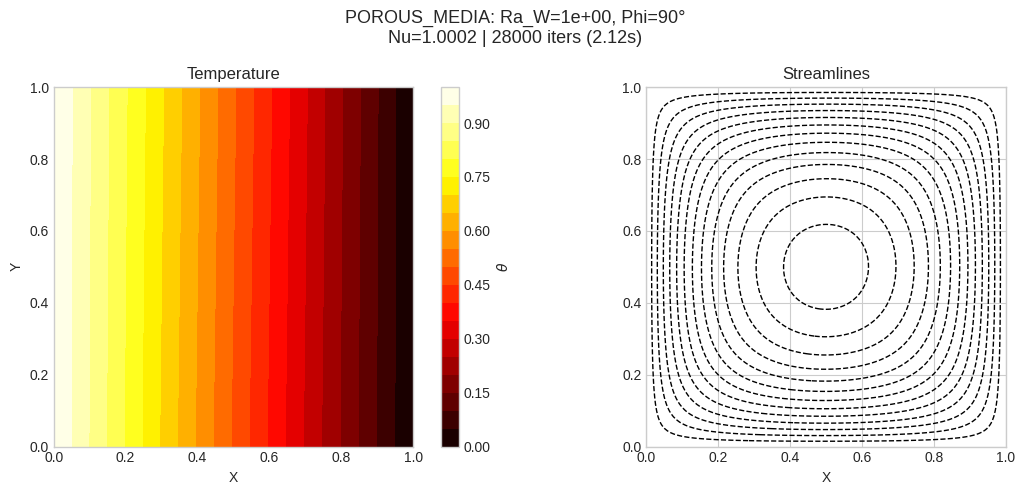

Run 2/9: AR=1, Ra_W=10, Angle=90°
   -> Result: Nu=1.0188 | Iters: 30000 | Time: 1.65s


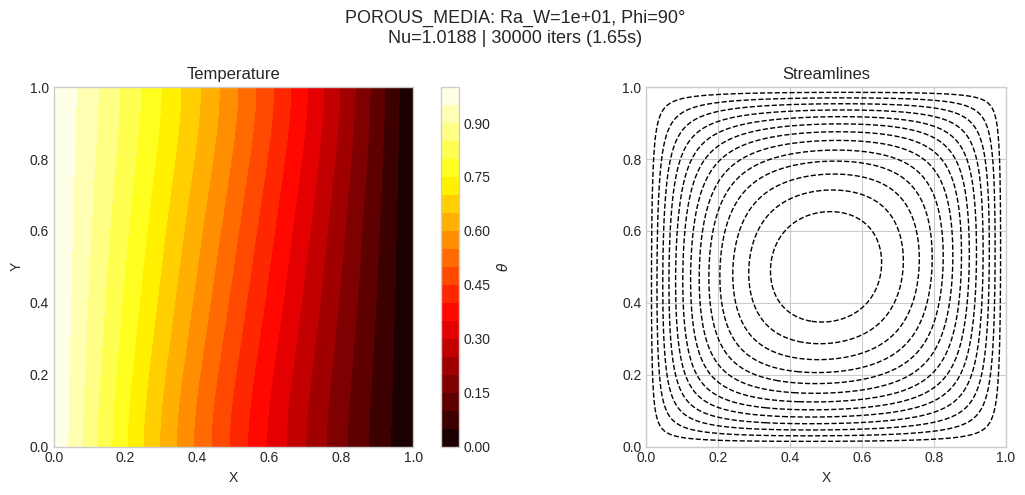

Run 3/9: AR=1, Ra_W=100, Angle=90°
   -> Result: Nu=2.6830 | Iters: 30000 | Time: 1.65s


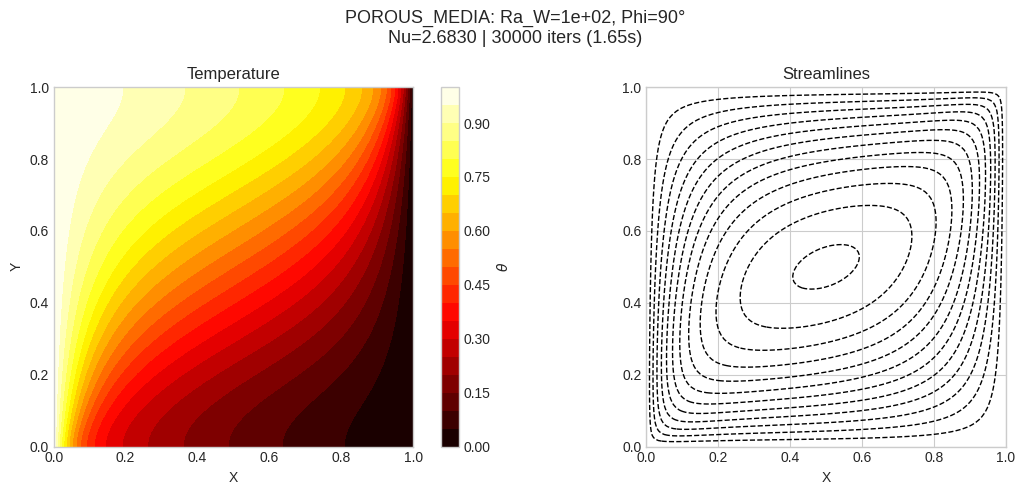

Run 4/9: AR=3, Ra_W=1, Angle=90°
   -> Result: Nu=1.0002 | Iters: 30000 | Time: 1.66s


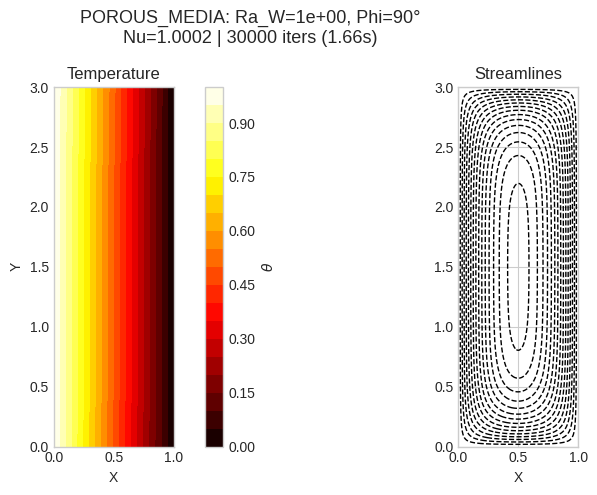

Run 5/9: AR=3, Ra_W=10, Angle=90°
   -> Result: Nu=1.0209 | Iters: 30000 | Time: 1.68s


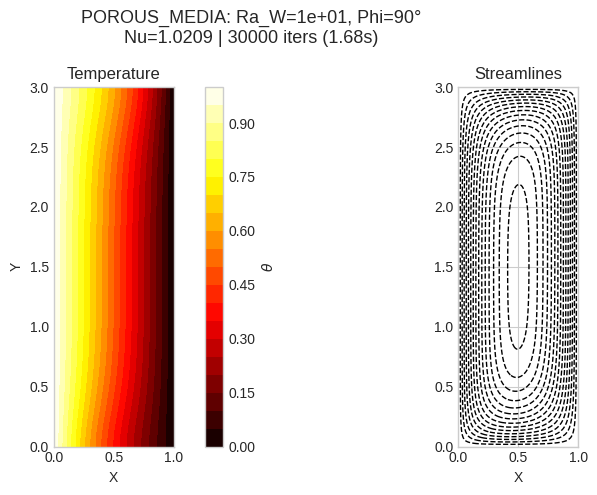

Run 6/9: AR=3, Ra_W=100, Angle=90°
   -> Result: Nu=2.2474 | Iters: 30000 | Time: 1.66s


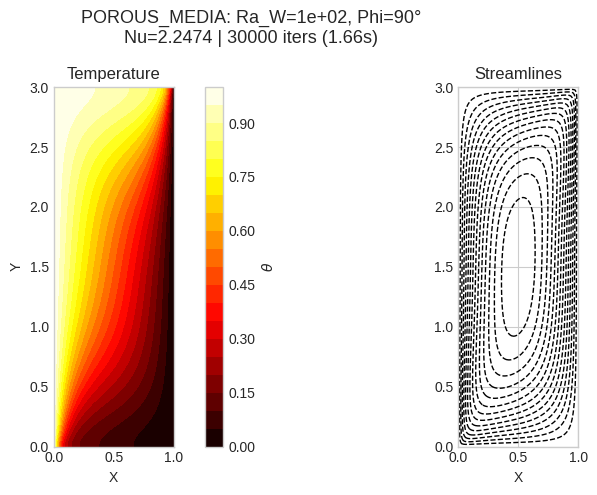

Run 7/9: AR=5, Ra_W=1, Angle=90°
   -> Result: Nu=1.0001 | Iters: 30000 | Time: 1.68s


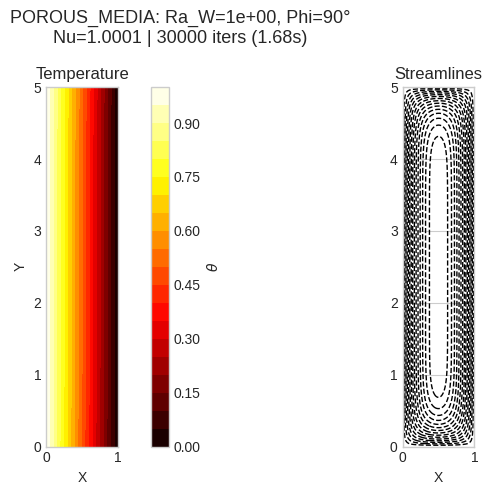

Run 8/9: AR=5, Ra_W=10, Angle=90°
   -> Result: Nu=1.0137 | Iters: 30000 | Time: 1.67s


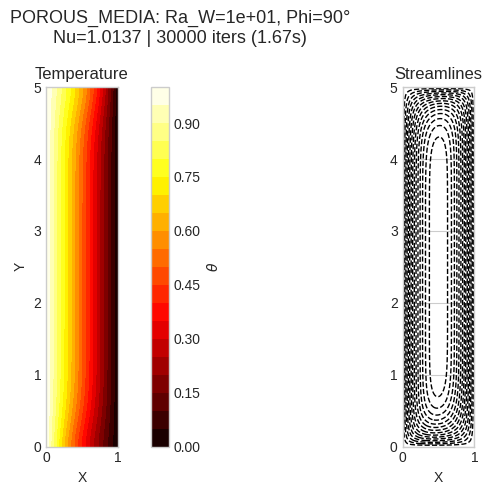

Run 9/9: AR=5, Ra_W=100, Angle=90°
   -> Result: Nu=1.7881 | Iters: 30000 | Time: 1.68s


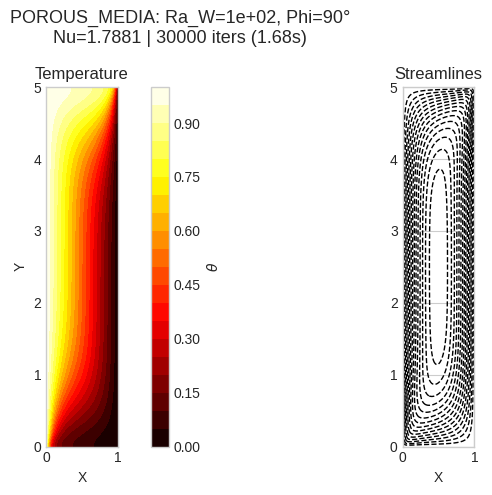


CAMPAIGN: Porous_Angle_Sensitivity_Ra100 (9 cases)
Run 1/9: AR=1, Ra_W=100, Angle=0°
   [Porous] Mode: Rayleigh-Bénard (Bottom-Heated, Angle=0)
   -> Result: Nu=2.6833 | Iters: 30000 | Time: 1.66s


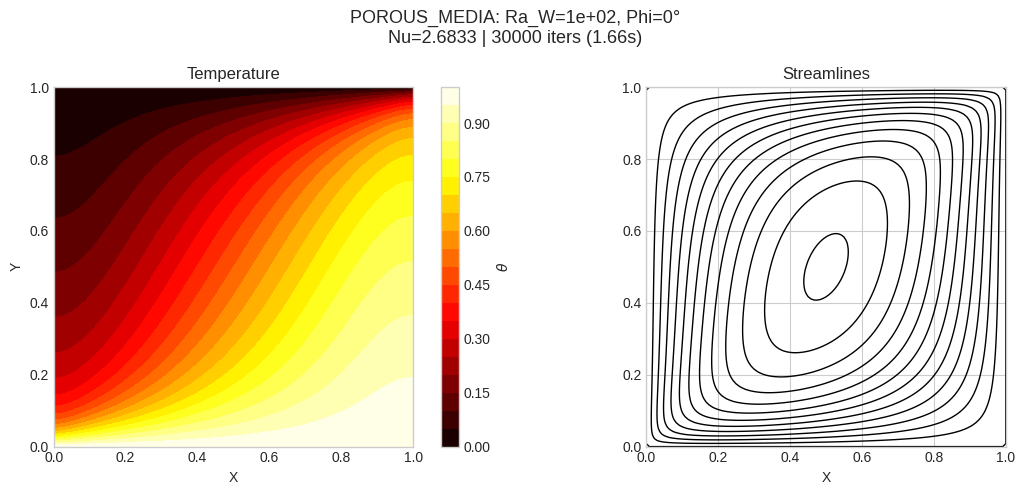

Run 2/9: AR=1, Ra_W=100, Angle=15°
   -> Result: Nu=1.2882 | Iters: 30000 | Time: 1.68s


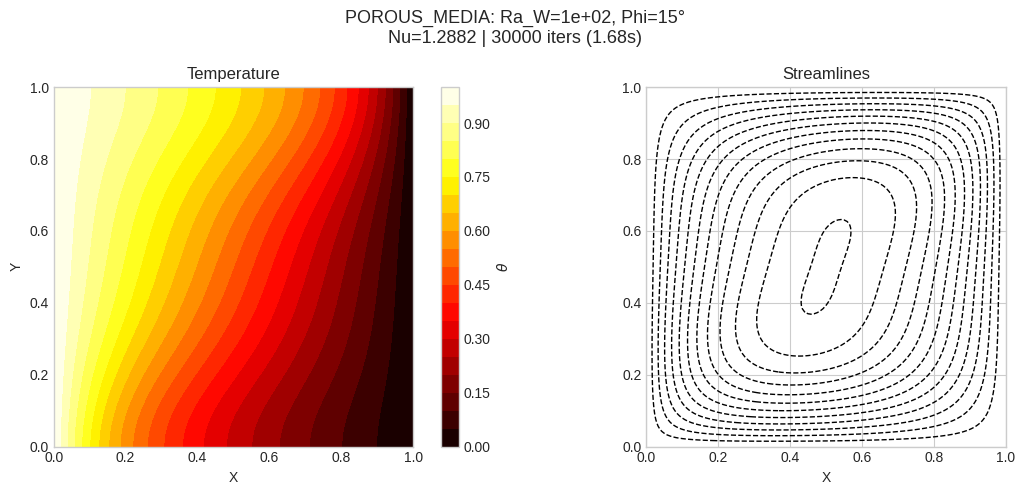

Run 3/9: AR=1, Ra_W=100, Angle=30°
   -> Result: Nu=1.9555 | Iters: 30000 | Time: 1.65s


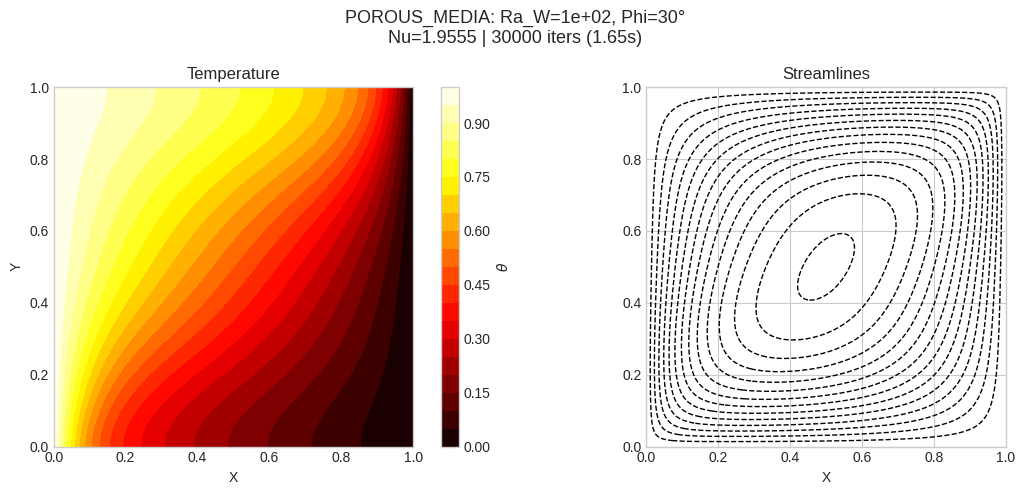

Run 4/9: AR=1, Ra_W=100, Angle=45°
   -> Result: Nu=2.5390 | Iters: 30000 | Time: 1.71s


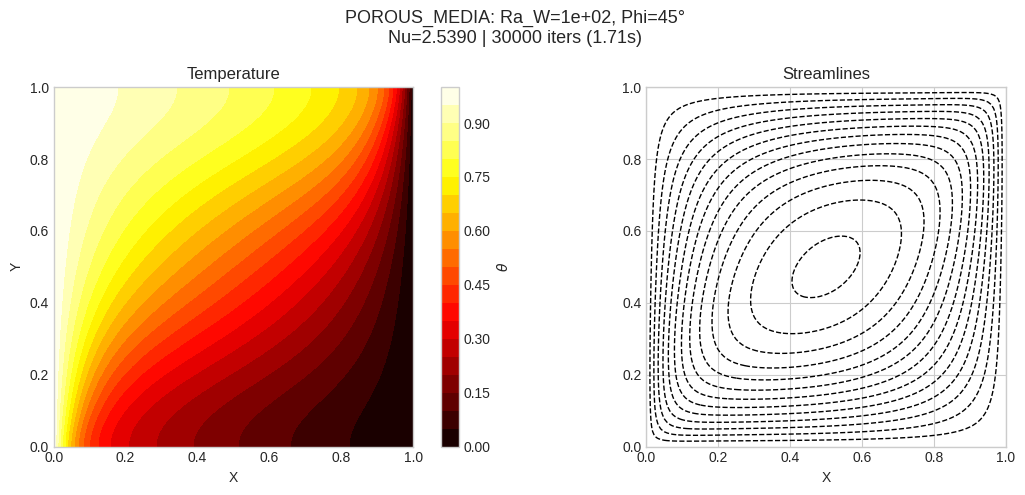

Run 5/9: AR=1, Ra_W=100, Angle=60°
   -> Result: Nu=2.8474 | Iters: 30000 | Time: 1.72s


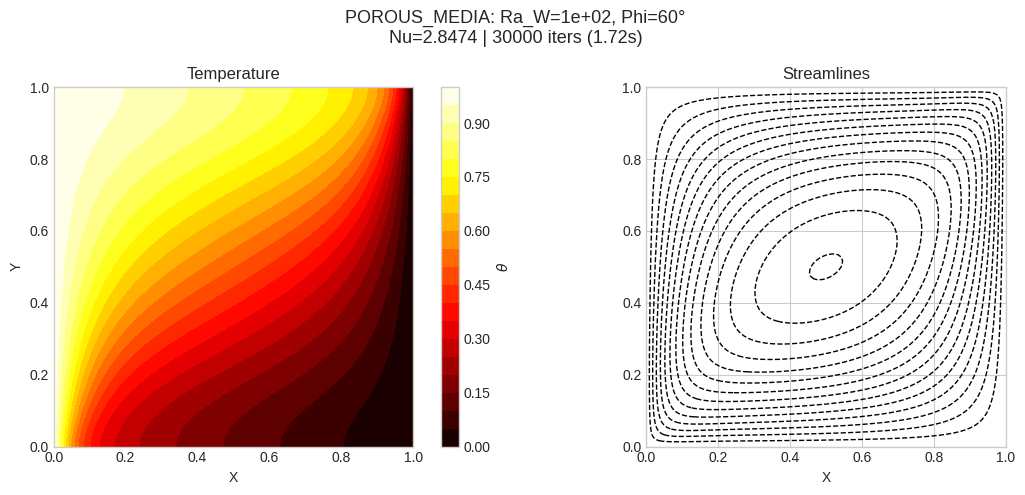

Run 6/9: AR=1, Ra_W=100, Angle=90°
   -> Result: Nu=2.6830 | Iters: 30000 | Time: 1.67s


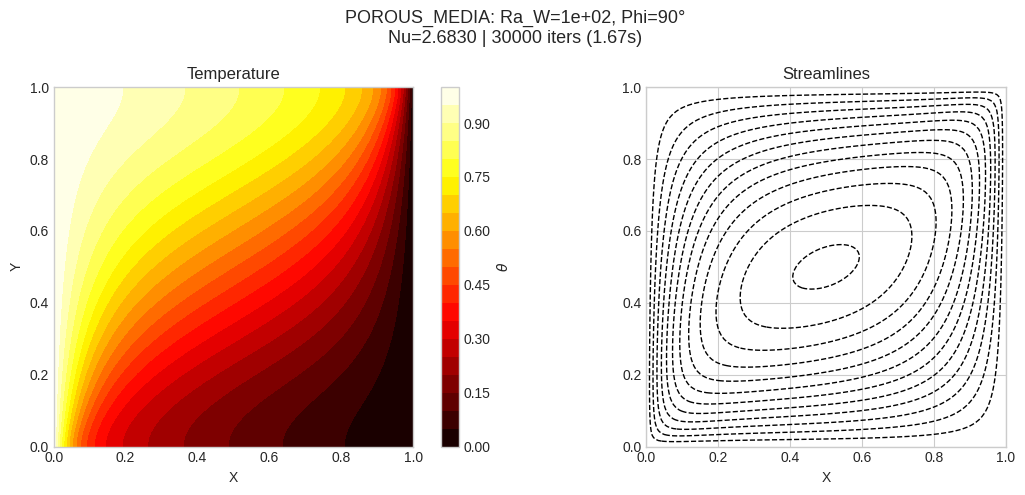

Run 7/9: AR=1, Ra_W=100, Angle=120°
   -> Result: Nu=1.9198 | Iters: 30000 | Time: 1.74s


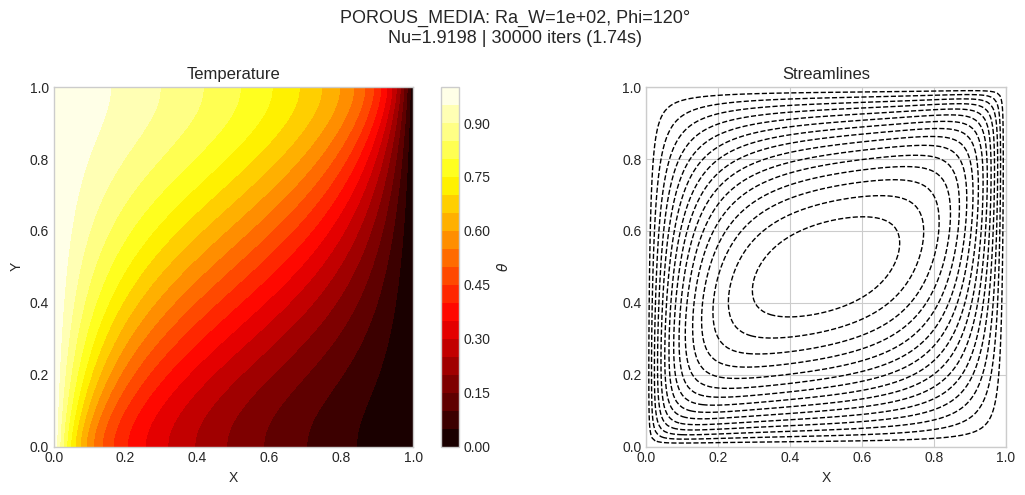

Run 8/9: AR=1, Ra_W=100, Angle=150°
   -> Result: Nu=1.2365 | Iters: 30000 | Time: 1.68s


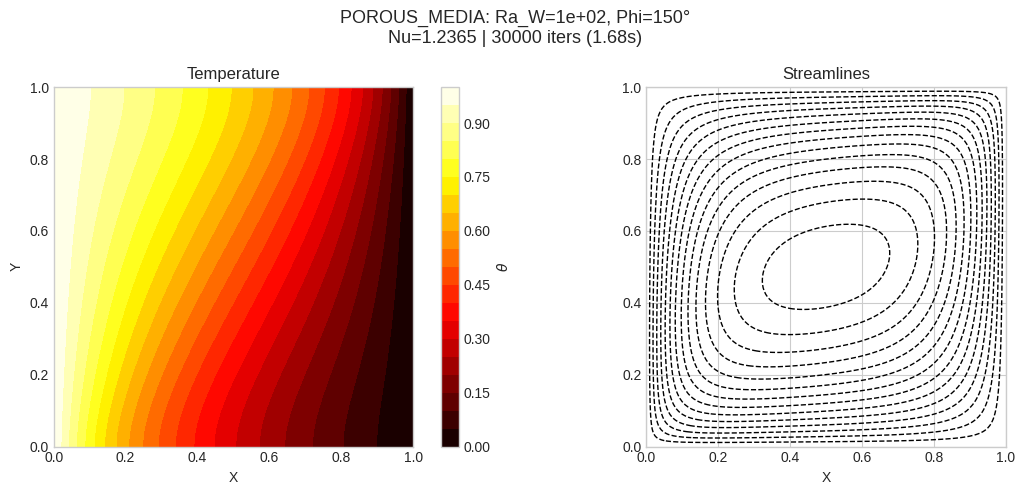

Run 9/9: AR=1, Ra_W=100, Angle=180°
   [Porous] Mode: Rayleigh-Bénard (Bottom-Heated, Angle=180)
   -> Result: Nu=2.6832 | Iters: 30000 | Time: 1.72s


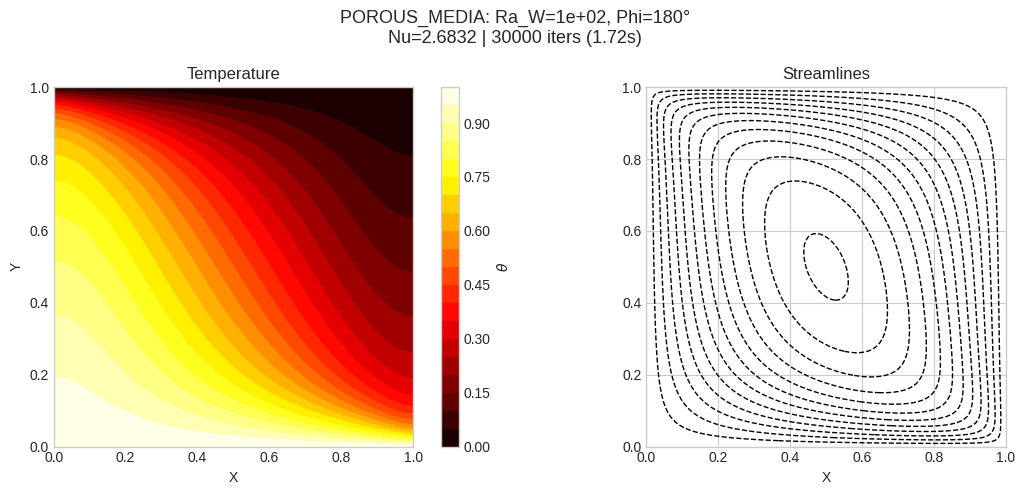


All Porous Media campaigns finished.


In [21]:
if __name__ == '__main__':
    
    # --- DEFINE POROUS CAMPAIGNS ---
    porous_campaigns = [
        # Campaign 1: Vertical Cavity Baseline
        {
            'name': 'Porous_Baseline_Vertical_90deg',
            'model': 'POROUS_MEDIA',
            'params': {
                'AR': [1, 3, 5], 
                'Ra': [1, 10, 100],  # This represents Ra_W (Porous Rayleigh)
                'Angle': [90], 
                'bc_type': ['adiabatic'] # Standard benchmark BC
            }
        },
        # Campaign 2: Angle Sensitivity (Stability Probe)
        {
            'name': 'Porous_Angle_Sensitivity_Ra100',
            'model': 'POROUS_MEDIA',
            'params': {
                'AR': [1], 
                'Ra': [100], 
                'Angle': [0, 15, 30, 45, 60, 90, 120, 150, 180], 
                'bc_type': ['adiabatic']
            }
        }
    ]

    print(f"Starting Porous Media Research Runs...")
    print(f"Output Directory: {os.path.abspath(OUTPUT_DIR)}")

    # --- EXECUTION LOOP ---
    for campaign in porous_campaigns:
        name = campaign['name']
        model = campaign['model']
        cases = generate_test_cases(campaign['params'])
        
        print(f"\n" + "="*60)
        print(f"CAMPAIGN: {name} ({len(cases)} cases)")
        print("="*60)
        
        for i, p in enumerate(cases):
            # Print status header
            print(f"Run {i+1}/{len(cases)}: AR={p['AR']}, Ra_W={p['Ra']}, Angle={p['Angle']}°")
            
            # 1. Configure
            config = {
                'model_type': model,
                'nx': NX, 'ny': NY,
                'a': p['AR'],
                'ra': p['Ra'],
                'phi_deg': p['Angle'],
                'bc_type': p['bc_type'],
                # Standard constants (unused by Porous kernel but required by config)
                'pr': PR, 'sc': SC, 'sr': SR,
                'omega_sor': OMEGA_SOR, 'tol': TOLERANCE, 'max_iter': MAX_ITER
            }
            
            # 2. Run Solver
            # The logic inside main_solver will automatically detect 'POROUS_MEDIA'
            # and apply the auto-stabilization for 0/180 degrees.
            res = main_solver(config)
            
            # 3. Report Results
            # Note: For porous media, we focus on Nu (Heat Transfer). 
            # Sh (Mass Transfer) is typically 0.0 or irrelevant unless explicitly coupled.
            if np.isnan(res['nu_avg']):
                 status = "DIVERGED"
            else:
                 status = f"Nu={res['nu_avg']:.4f}"
                 
            print(f"   -> Result: {status} | Iters: {res['iter_count']} | Time: {res['runtime']:.2f}s")

            # 4. Optional: Visualize Live
            if PLOT_RESULTS:
                y_coords = np.linspace(0, config['a'], config['ny'])

                plot_final_results(
                    res['psi'], res['theta'], res['C'], 
                    res['X'], y_coords, 
                    config, res['nu_avg'], res['sh_avg'], 
                    res['runtime'], res['iter_count']
                )

    print("\nAll Porous Media campaigns finished.")

Compiling Numba functions...

--- Campaign1_Vary_AR_Ra ---
AR=1   Ra=1     Angle=90  | Nu=1.0006
AR=1   Ra=5     Angle=90  | Nu=1.0192
AR=1   Ra=10    Angle=90  | Nu=1.0740
AR=1   Ra=50    Angle=90  | Nu=1.9795
AR=1   Ra=100   Angle=90  | Nu=3.1231
AR=3   Ra=1     Angle=90  | Nu=1.0006
AR=3   Ra=5     Angle=90  | Nu=1.0154
AR=3   Ra=10    Angle=90  | Nu=1.0591
AR=3   Ra=50    Angle=90  | Nu=1.7643
AR=3   Ra=100   Angle=90  | Nu=2.6050
AR=5   Ra=1     Angle=90  | Nu=1.0003
AR=5   Ra=5     Angle=90  | Nu=1.0092
AR=5   Ra=10    Angle=90  | Nu=1.0356
AR=5   Ra=50    Angle=90  | Nu=1.4880
AR=5   Ra=100   Angle=90  | Nu=2.1031

--- Campaign2_Vary_Angle ---
   [Porous] Mode: Rayleigh-Bénard (Bottom-Heated, Angle=0)
AR=1   Ra=100   Angle=0   | Nu=3.1226
AR=1   Ra=100   Angle=15  | Nu=3.2627
AR=1   Ra=100   Angle=30  | Nu=3.6561
AR=1   Ra=100   Angle=45  | Nu=3.8359
AR=1   Ra=100   Angle=60  | Nu=3.8016
AR=1   Ra=100   Angle=90  | Nu=3.1231
AR=1   Ra=100   Angle=120 | Nu=1.9833
AR=1   Ra=100   

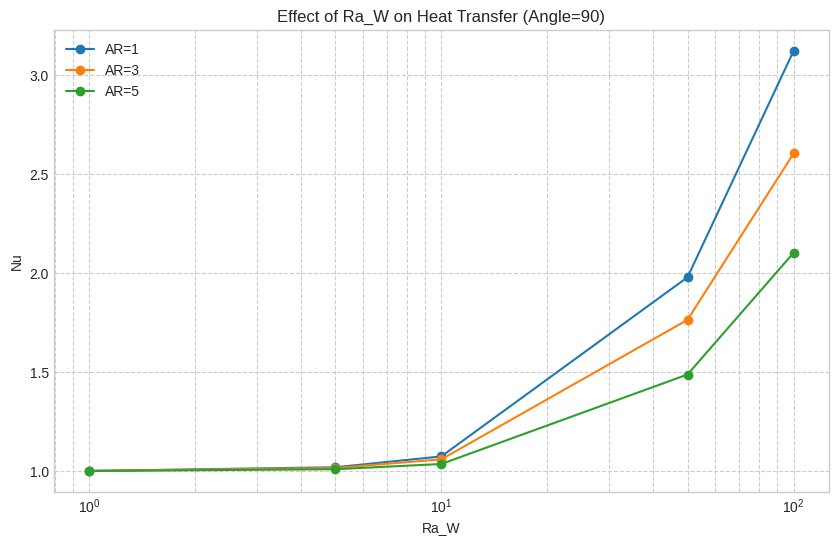

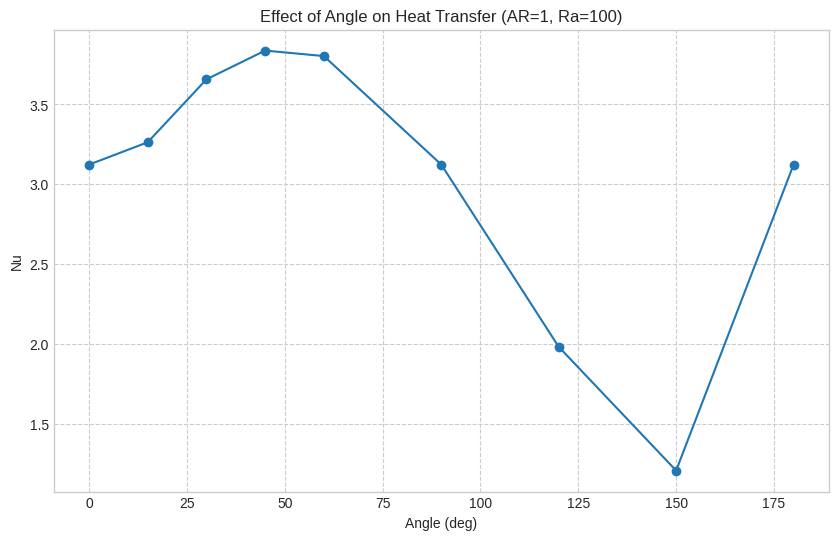

In [22]:
# Constants
NX = 121
NY = 121
TOLERANCE = 1e-6
MAX_ITER = 20000
OMEGA_SOR = 1.0 # Your porous kernel likes 1.0 (SOR) or under-relaxation
OUTPUT_DIR = "results/raw_fields"

if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print("Compiling Numba functions...")

    # Define Campaigns (Exactly as in your code)
    campaigns = [
        {
            'name': 'Campaign1_Vary_AR_Ra',
            'params': {'AR': [1, 3, 5], 'Ra': [1, 5, 10, 50, 100], 'Angle': [90]}
        },
        {
            'name': 'Campaign2_Vary_Angle',
            'params': {'AR': [1], 'Ra': [100], 'Angle': [0, 15, 30, 45, 60, 90, 120, 150, 180]}
        }
    ]
    
    all_results = {}

    for camp in campaigns:
        print(f"\n--- {camp['name']} ---")
        
        # Generate cases
        keys = camp['params'].keys()
        vals = camp['params'].values()
        cases = [dict(zip(keys, v)) for v in itertools.product(*vals)]
        
        results_list = []
        
        for case in cases:
            # Config dictionary
            config = {
                'model_type': 'POROUS_MEDIA',
                'nx': NX, 'ny': NY,
                'a': case['AR'],
                'ra': case['Ra'],
                'phi_deg': case['Angle'],
                'bc_type': 'adiabatic',
                'omega_sor': OMEGA_SOR, 'tol': TOLERANCE, 'max_iter': MAX_ITER
            }
            
            # Run
            res = main_solver(config)
            
            # Store & Print
            metric = {'AR': case['AR'], 'Ra': case['Ra'], 'Angle': case['Angle'], 'Nu': res['nu_avg']}
            results_list.append(metric)
            print(f"AR={case['AR']:<3} Ra={case['Ra']:<5} Angle={case['Angle']:<3} | Nu={res['nu_avg']:.4f}")
            
            # Save Raw CSVs (as requested)
            fname_theta = f"theta_AR{case['AR']}_Ra{case['Ra']}_Angle{case['Angle']}.csv"
            fname_psi   = f"psi_AR{case['AR']}_Ra{case['Ra']}_Angle{case['Angle']}.csv"
            np.savetxt(os.path.join(OUTPUT_DIR, fname_theta), res['theta'], delimiter=",", fmt="%.6f")
            np.savetxt(os.path.join(OUTPUT_DIR, fname_psi), res['psi'], delimiter=",", fmt="%.6f")
            
        all_results[camp['name']] = pd.DataFrame(results_list)

    # --- Plotting (Reproducing your plots) ---
    print("\nGenerating Plots...")
    
    # Plot 1: Ra vs Nu for different AR
    df1 = all_results['Campaign1_Vary_AR_Ra']
    plt.figure(figsize=(10, 6))
    for ar in df1['AR'].unique():
        subset = df1[df1['AR'] == ar]
        plt.plot(subset['Ra'], subset['Nu'], 'o-', label=f'AR={ar}')
    plt.xscale('log')
    plt.xlabel('Ra_W')
    plt.ylabel('Nu')
    plt.title('Effect of Ra_W on Heat Transfer (Angle=90)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
    
    # Plot 2: Angle vs Nu
    df2 = all_results['Campaign2_Vary_Angle']
    plt.figure(figsize=(10, 6))
    plt.plot(df2['Angle'], df2['Nu'], 'o-')
    plt.xlabel('Angle (deg)')
    plt.ylabel('Nu')
    plt.title('Effect of Angle on Heat Transfer (AR=1, Ra=100)')
    plt.grid(True, ls="--")
    plt.show()